In [1]:
import numpy as np 
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cpu'

In [3]:
# Load data
data = np.load('master_data/data.npy')

In [4]:
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


## AE

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(250, 125).double()
        self.linear2 = nn.Linear(125, latent_dims).double()
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 125).double()
        self.linear2 = nn.Linear(125, 250).double()
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        # print(z.shape)
        z = z.reshape(363, 250)
        # print(z.shape)
        return z

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [317]:
def train_ae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_total_to_plot = []
    for epoch in range(epochs):
        for i, batch in enumerate(data):
            batch= np.transpose(batch)
            batch = batch[:, np.random.permutation(batch.shape[1])]
            # print(batch.shape)
            x = torch.from_numpy(batch) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_total_to_plot.append(loss.item())
            print('Epoch %s/%s, batch %s ,Loss=%s' % (epoch+1, epochs,i, loss.item()))
    
    fig, axes = plt.subplots()
    x_points = range(0, len(loss_total_to_plot))
    axes.set_title("Total loss", fontsize=10, y=1.022)
    axes.plot(x_points, loss_total_to_plot, color="black", label="Total", linewidth=5)
    axes.yaxis.grid(True, zorder=0)
    axes.set_xlabel('Iteration', fontsize=10)

    return autoencoder

Epoch 1/20, batch 0 ,Loss=tensor(22866.8065, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 1 ,Loss=tensor(22373.7673, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 2 ,Loss=tensor(21930.9327, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 3 ,Loss=tensor(21433.4405, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 4 ,Loss=tensor(20946.2514, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 5 ,Loss=tensor(20497.3945, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 6 ,Loss=tensor(20114.0072, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 7 ,Loss=tensor(19624.5549, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 8 ,Loss=tensor(19129.1608, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 9 ,Loss=tensor(18663.1415, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/20, batch 10 ,Loss=tensor(18174.4885, dtype=torch.float64, grad_fn=<SumBackward0>)
Epoch 1/2

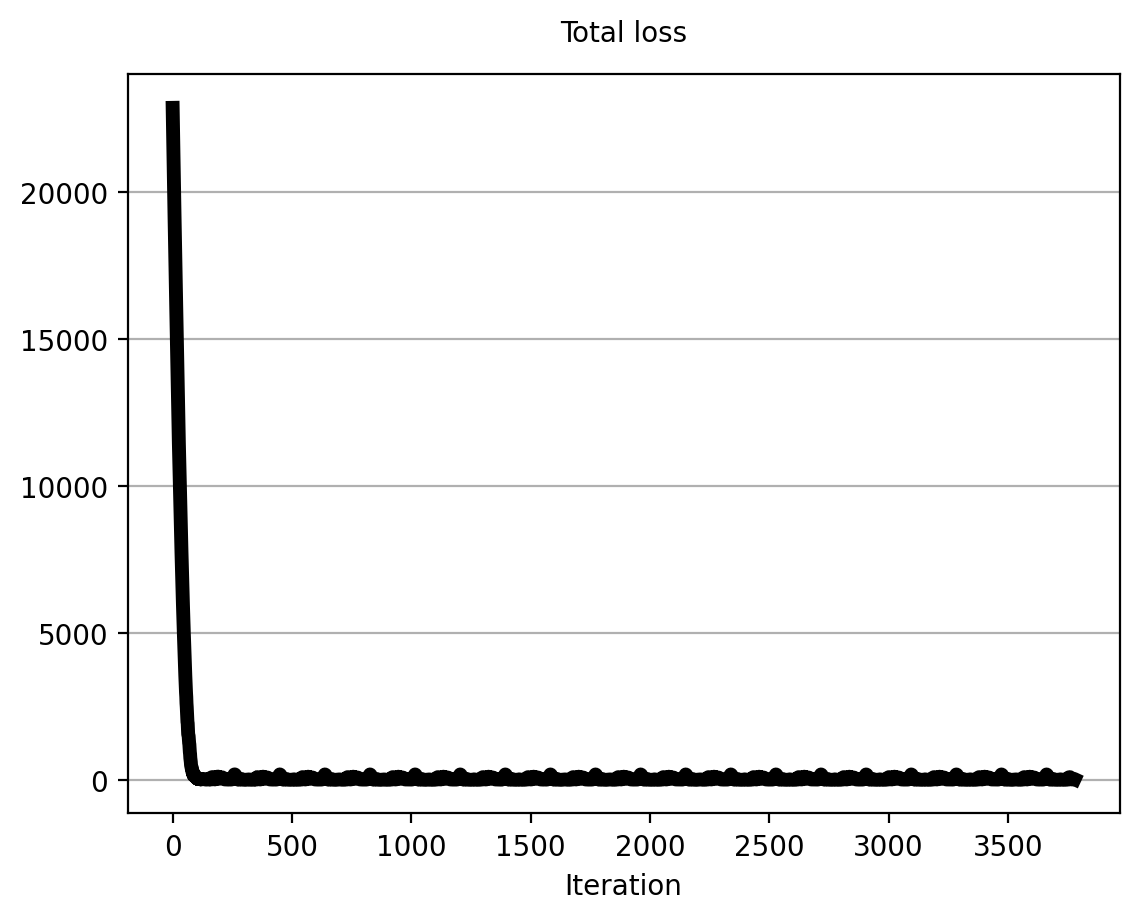

In [116]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train_ae(autoencoder, data, 20)

In [117]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, batch in enumerate(data):
        batch= np.transpose(batch)
        x = torch.from_numpy(batch)
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1] ,cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
        return z

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_17891/238154398.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1] ,cmap='tab10')


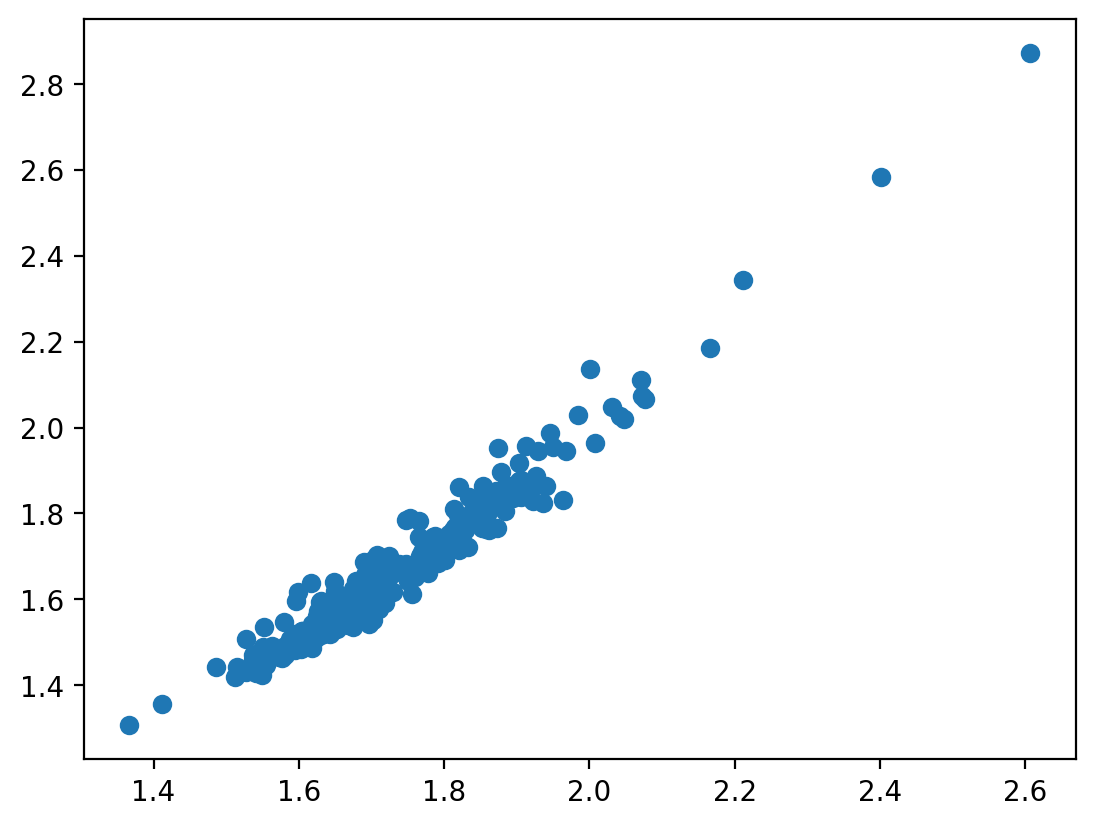

In [118]:
z = plot_latent(autoencoder, data)

In [119]:
z.shape

(363, 2)

In [120]:
data.shape

(189, 250, 363)

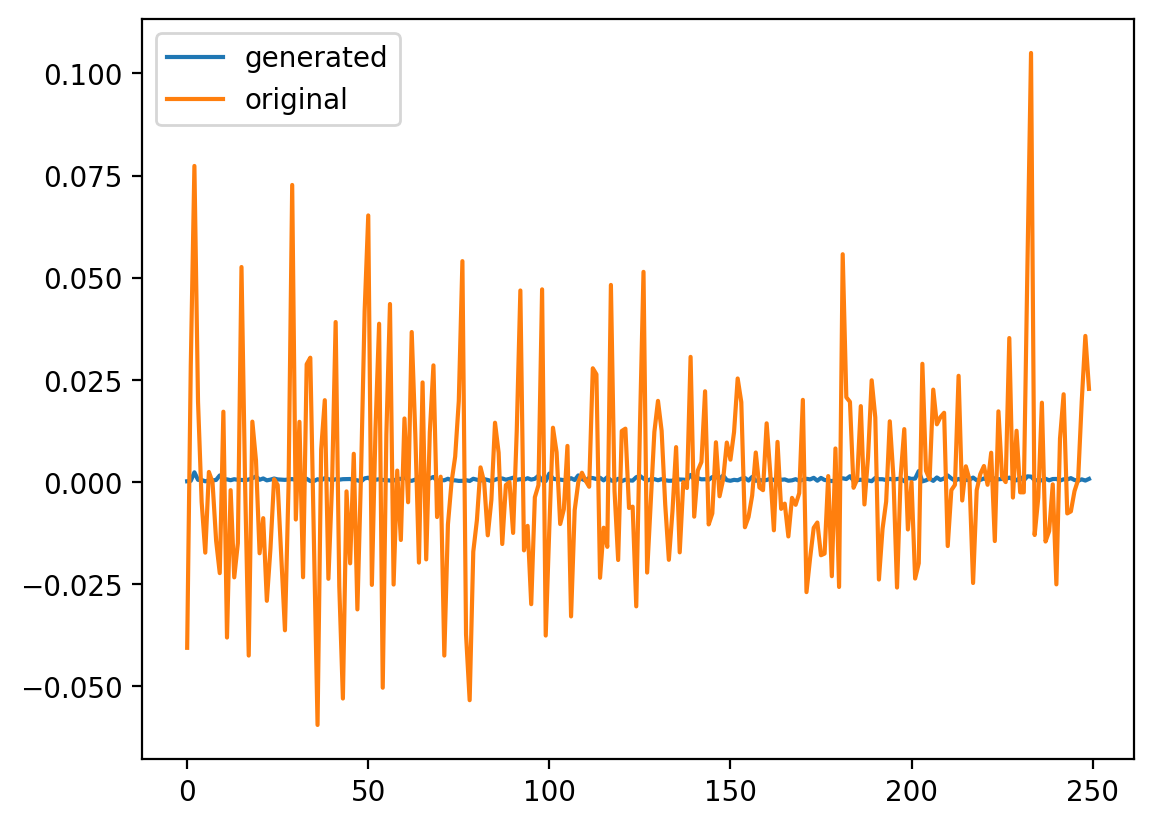

In [123]:
batch= data[0]
batch= np.transpose(batch)
x = torch.from_numpy(batch)
z = autoencoder.encoder(x.to(device))
x_hat = autoencoder.decoder(z)
x_hat = x_hat.to('cpu').detach().numpy()
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

## VAE 

In [226]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(250, 125).double()
        self.linear2 = nn.Linear(125, latent_dims).double()
        self.linear3 = nn.Linear(125, latent_dims).double()
        self.N = torch.distributions.Normal(0,1)
        # self.N = torch.distributions.Normal(
        #     torch.tensor(0).to(device=device), 
        #     torch.tensor(1).to(device=device))
        # self.N.loc = self.N.loc.mps() # hack to get sampling on the GPU
        # self.N.scale = self.N.scale.mps()
        self.kl = 0
    
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [259]:
class VariationalDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 125).double()
        self.linear2 = nn.Linear(125, 250).double()
        
    def forward(self, z):
        z = F.leaky_relu(self.linear1(z))
        z = self.linear2(z)
        # print(z.shape)
        z = z.reshape(363, 250)
        # print(z.shape)
        return z

In [260]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = VariationalDecoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [340]:
def train_vae(vautoencoder, data, epochs=20, learning_rate=0.0001, lambda_rec=0.7, lambda_reg=0.3 ):
    opt = torch.optim.Adam(vautoencoder.parameters(), lr=learning_rate)
    loss_total_to_plot = []
    for epoch in range(epochs):
        for i, batch in enumerate(data):
            batch= np.transpose(batch)
            batch = batch[:, np.random.permutation(batch.shape[1])]
            # print(batch.shape)
            x = torch.from_numpy(batch) # GPU
            opt.zero_grad()
            x_hat = vautoencoder(x)
            loss_recon = ((x - x_hat)**2).sum()
            reg_loss = vautoencoder.encoder.kl
            loss = lambda_rec*loss_recon + lambda_reg*reg_loss
            # loss = 0.7*((x - x_hat)**2).sum() + 0.3*vautoencoder.encoder.kl
            loss.backward()
            opt.step()
            loss_total_to_plot.append(loss.item())
            print('Epoch %s/%s, batch %s ,Loss=%s' % (epoch+1, epochs,i, loss))
    
    fig, axes = plt.subplots()
    x_points = range(0, len(loss_total_to_plot))
    axes.set_title("Total loss", fontsize=10, y=1.022)
    axes.plot(x_points, loss_total_to_plot, color="black", label="Total", linewidth=5)
    axes.yaxis.grid(True, zorder=0)
    axes.set_xlabel('Iteration', fontsize=10)

    return vautoencoder

In [262]:
latent_dims = 4
vae = VariationalAutoencoder(latent_dims).to(device) # GPU

Epoch 1/5, batch 0 ,Loss=tensor(4981.8264, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 1 ,Loss=tensor(4881.1757, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 2 ,Loss=tensor(4811.6855, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 3 ,Loss=tensor(4681.3130, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 4 ,Loss=tensor(4934.0996, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 5 ,Loss=tensor(4499.1543, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 6 ,Loss=tensor(4173.6448, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 7 ,Loss=tensor(4493.4683, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 8 ,Loss=tensor(4122.7840, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 9 ,Loss=tensor(4417.6766, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 10 ,Loss=tensor(4318.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 11 ,Loss=tenso

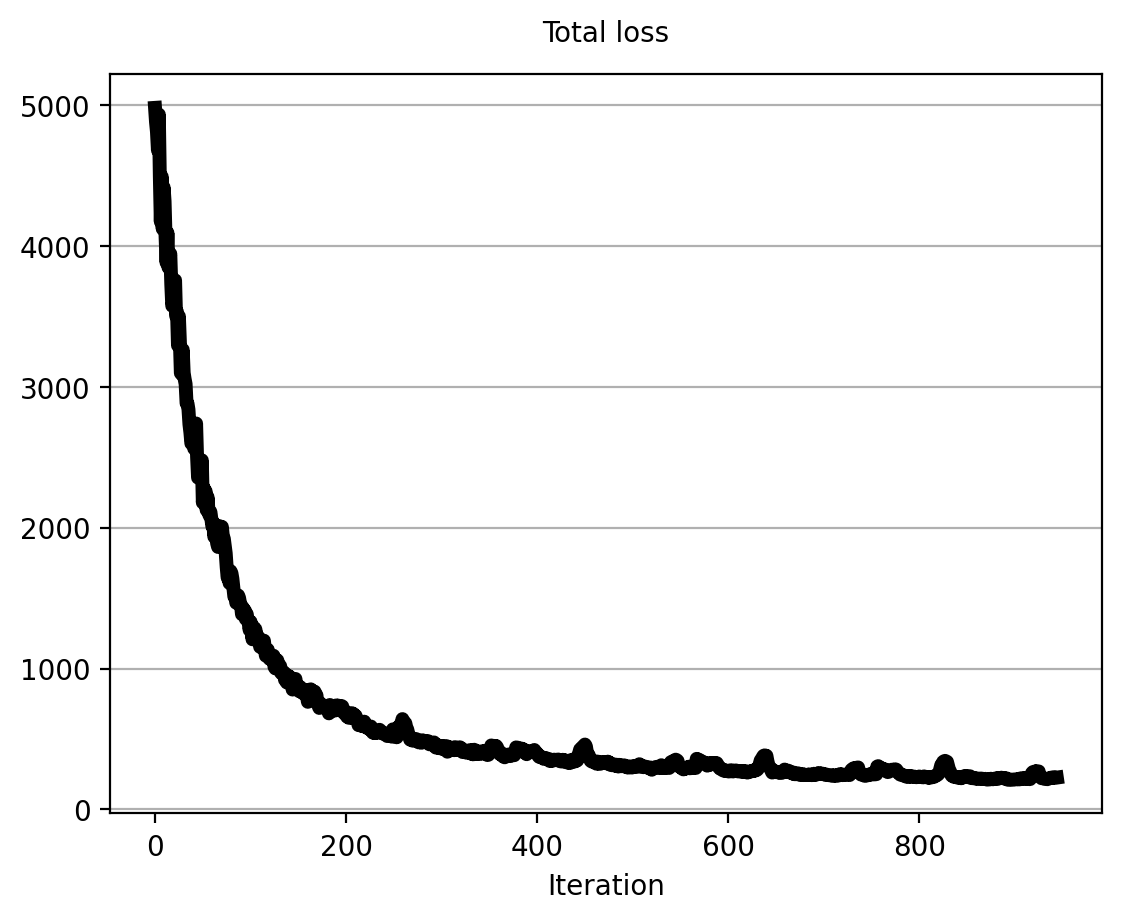

In [263]:
vae = train_vae(vae, data, 5, epochs=20, learning_rate=0.0001, lambda_rec=0.7, lambda_reg=0.3)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_17891/238154398.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1] ,cmap='tab10')


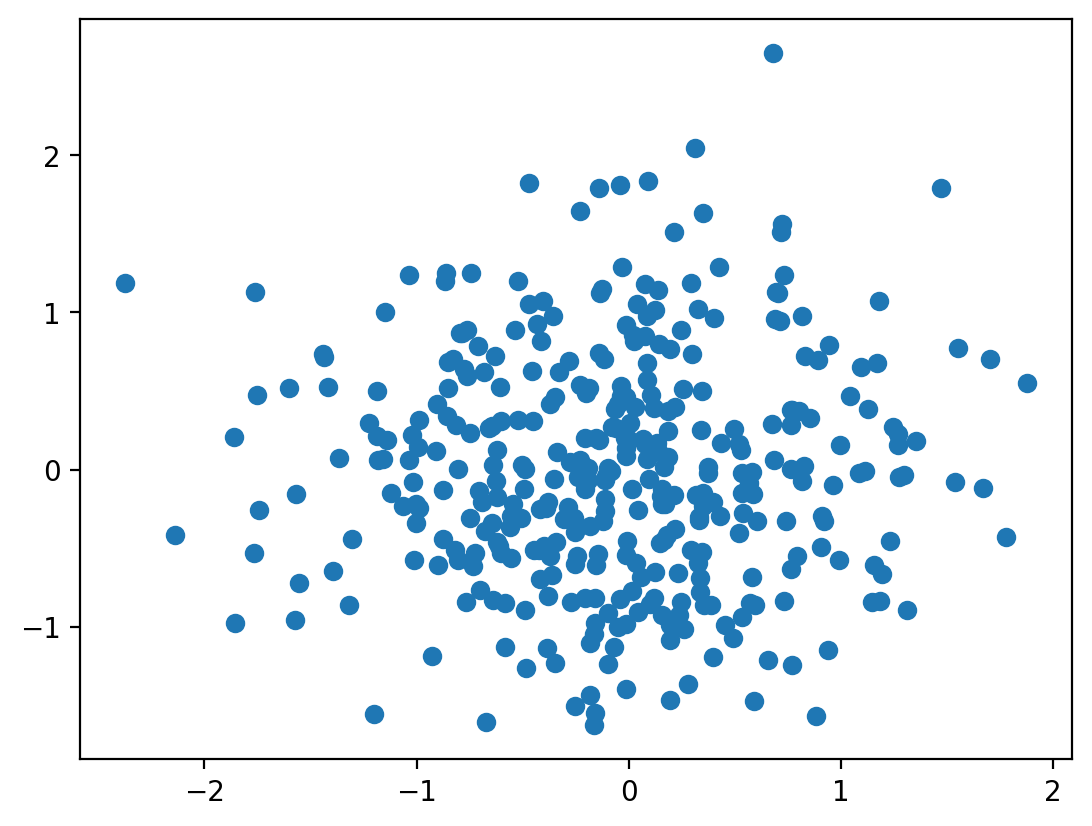

In [264]:
z = plot_latent(vae, data)

In [265]:
z.shape

(363, 4)

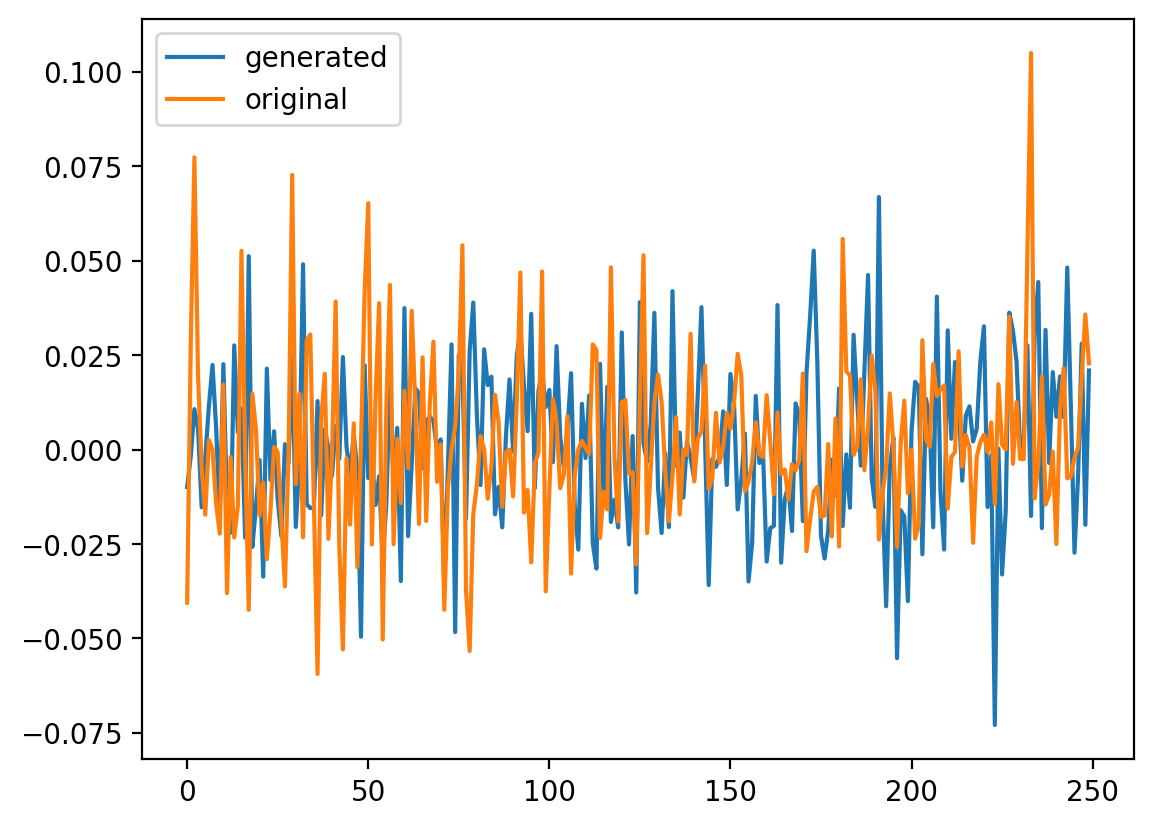

In [329]:
batch= data[0]
batch= np.transpose(batch)
x = torch.from_numpy(batch)
z = vae.encoder(x.to(device))
x_hat = vae.decoder(z)
x_hat = x_hat.to('cpu').detach().numpy()
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

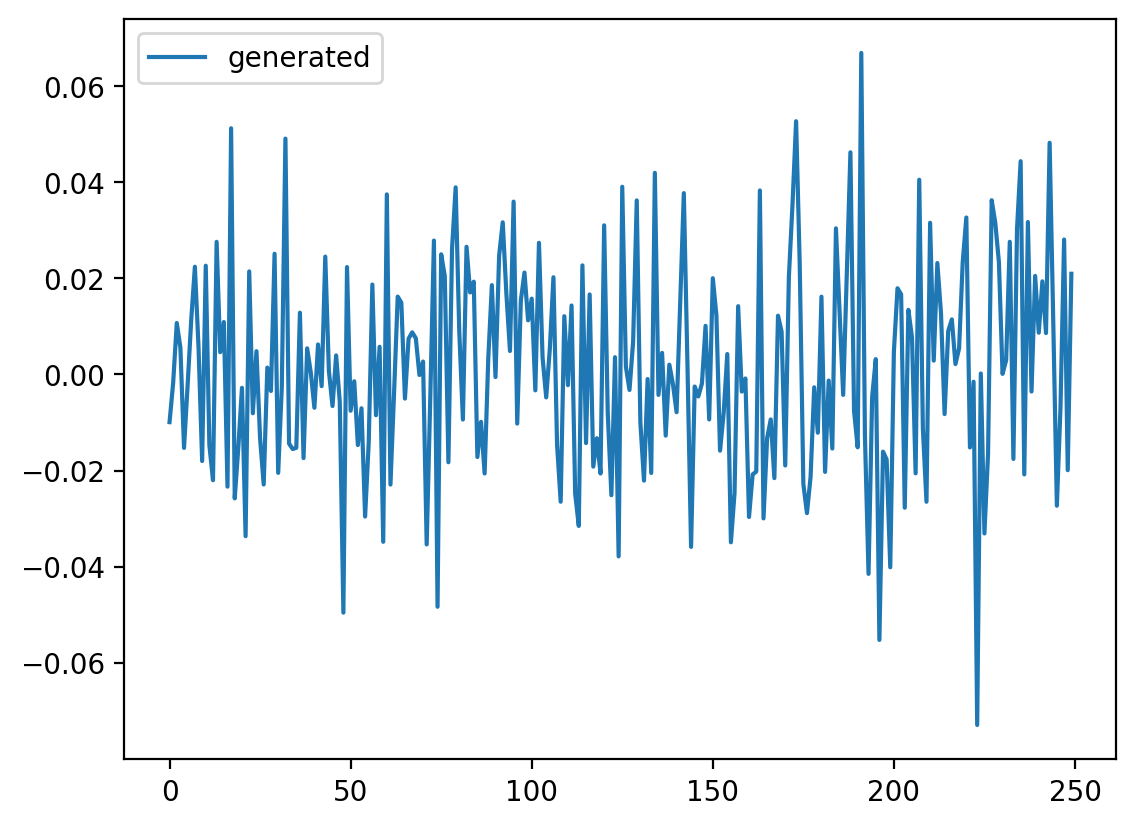

In [333]:
plt.plot(x_hat[0, :], label='generated')
plt.legend()
plt.show()

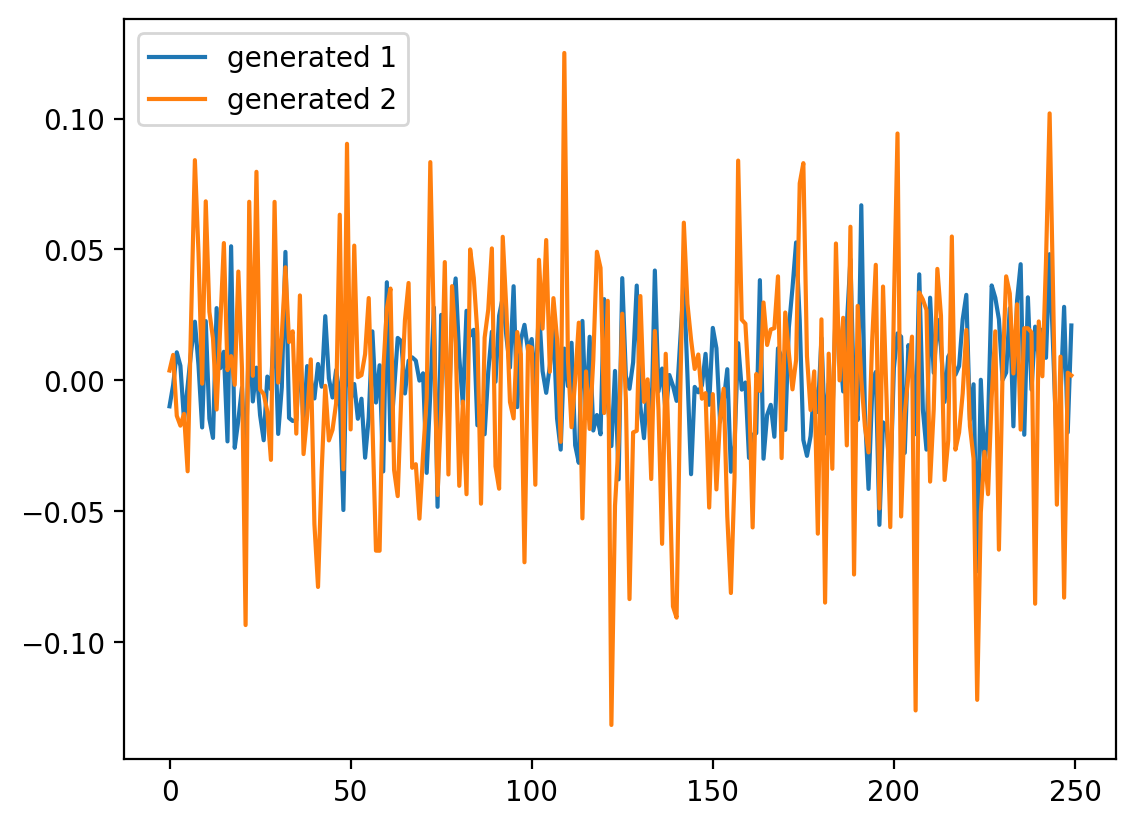

In [335]:
plt.plot(x_hat[0, :], label='generated 1')
plt.plot(x_hat[40, :], label='generated 2')
plt.legend()
plt.show()

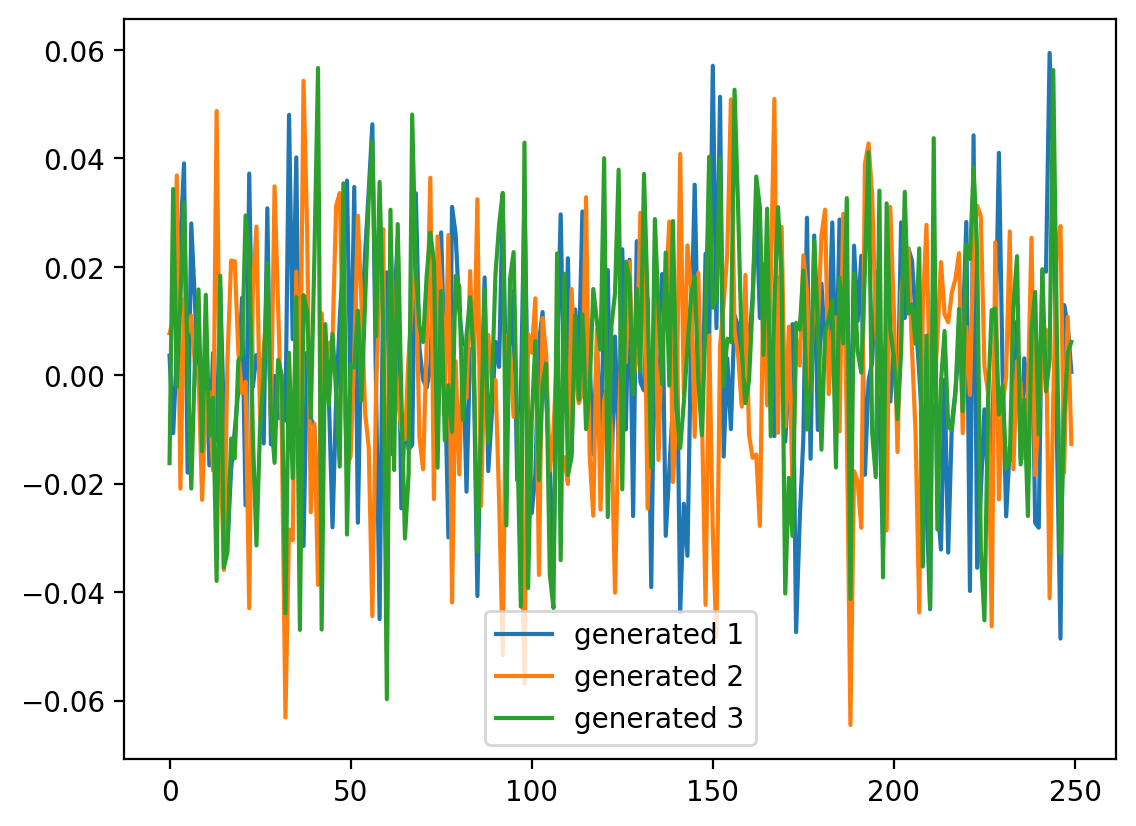

In [337]:
plt.plot(x_hat[20, :], label='generated 1')
plt.plot(x_hat[10, :], label='generated 2')
plt.plot(x_hat[100, :], label='generated 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

In [270]:
z_samples = np.random.normal(loc=0.0, scale=1.0, size=[363,4])
z_samples.shape

(363, 4)

In [352]:
def synthesize(enc_dec_net,
               n_samples, z_dims=4):
    # enc_dec_net: Network with encoder and decoder, pretrained.
    # n_samples: how many samples to produce.
    
    
    ############################## TODO: Fill in the blanks #############################
    # Create samples of z from Gaussian N(0,I), where means are 0 and standard deviations are 1 in all dimensions.
    z_samples = np.random.normal(loc=0.0, scale=1.0, size=[363, z_dims])
    #####################################################################################
    
    z_samples_t = torch.tensor(z_samples, dtype=torch.float64)
    print(z_samples_t.shape)
    x_samples = enc_dec_net.decoder(z_samples_t)
    
    x_samples_np = x_samples if type(x_samples) is np.ndarray else x_samples.detach().numpy()  # torch to numpy

    # return   x_samples_np    
    for i, x_sample in enumerate(x_samples_np):
        plt.plot(x_sample)
        plt.show()
        plt.pause(0.1)
        if i > n_samples:
            break

    return x_samples_np  

torch.Size([363, 4])


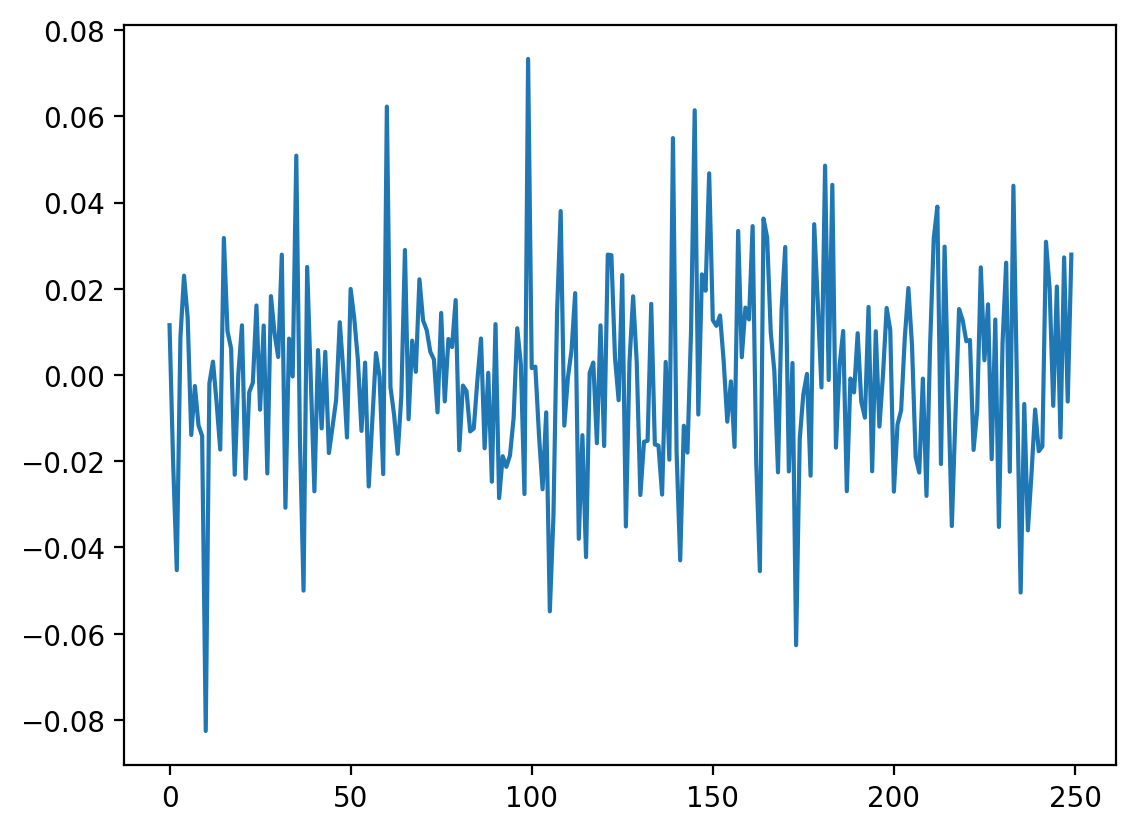

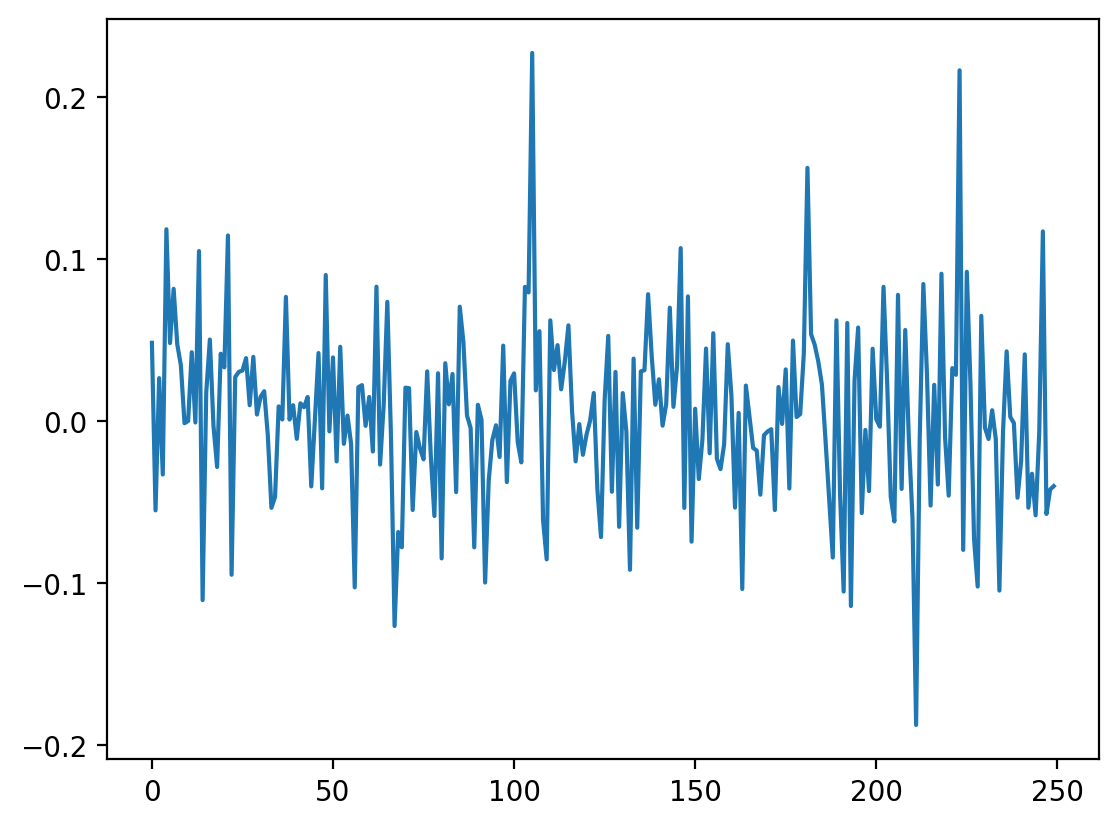

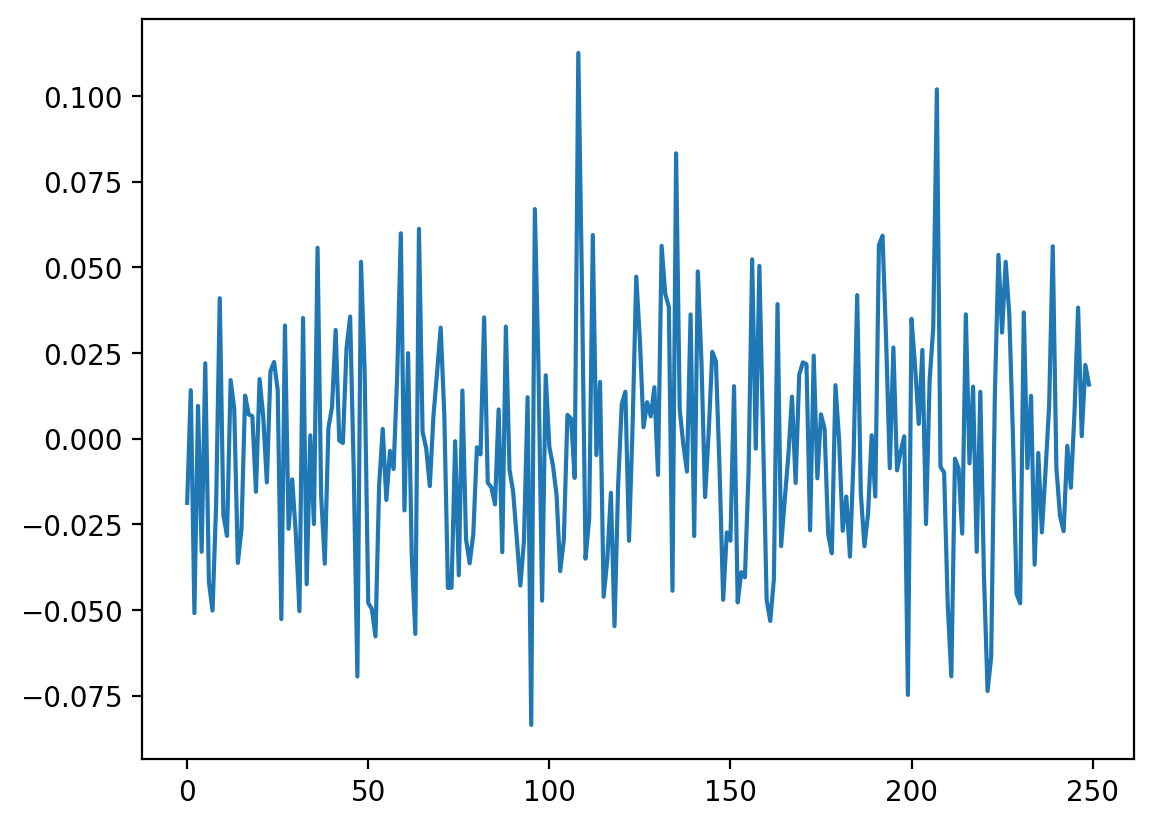

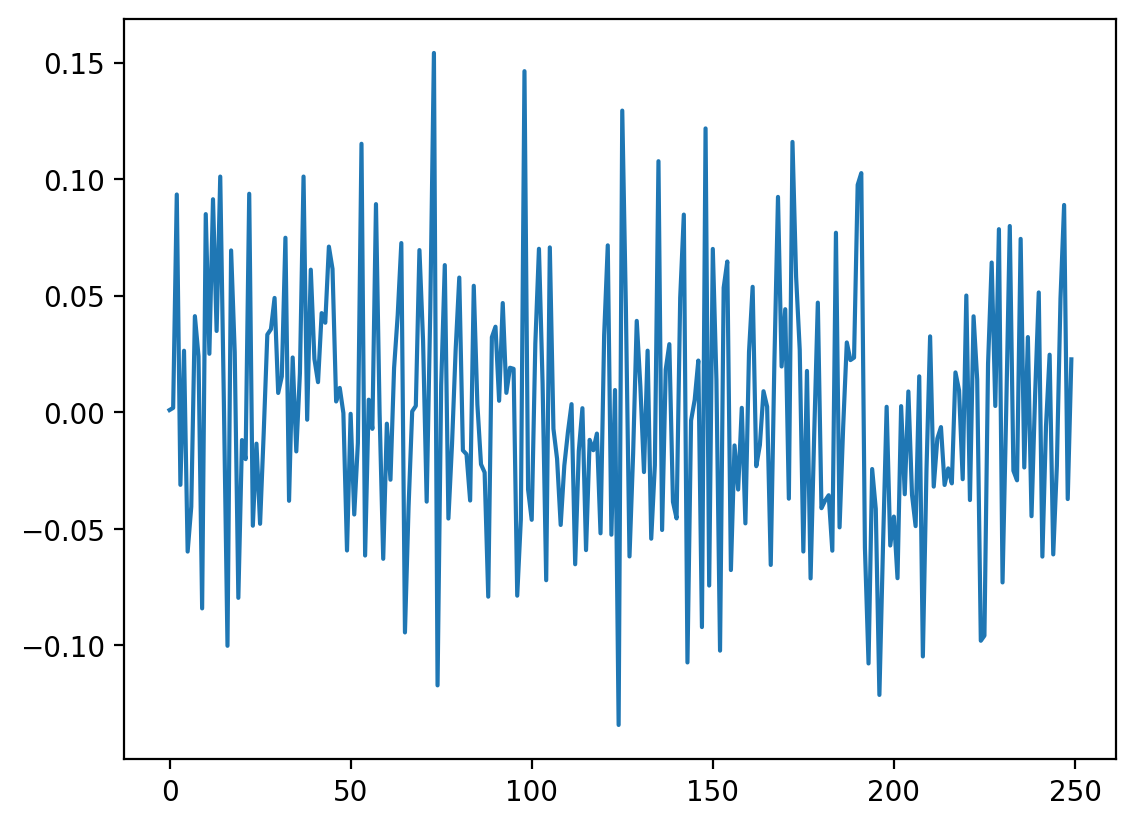

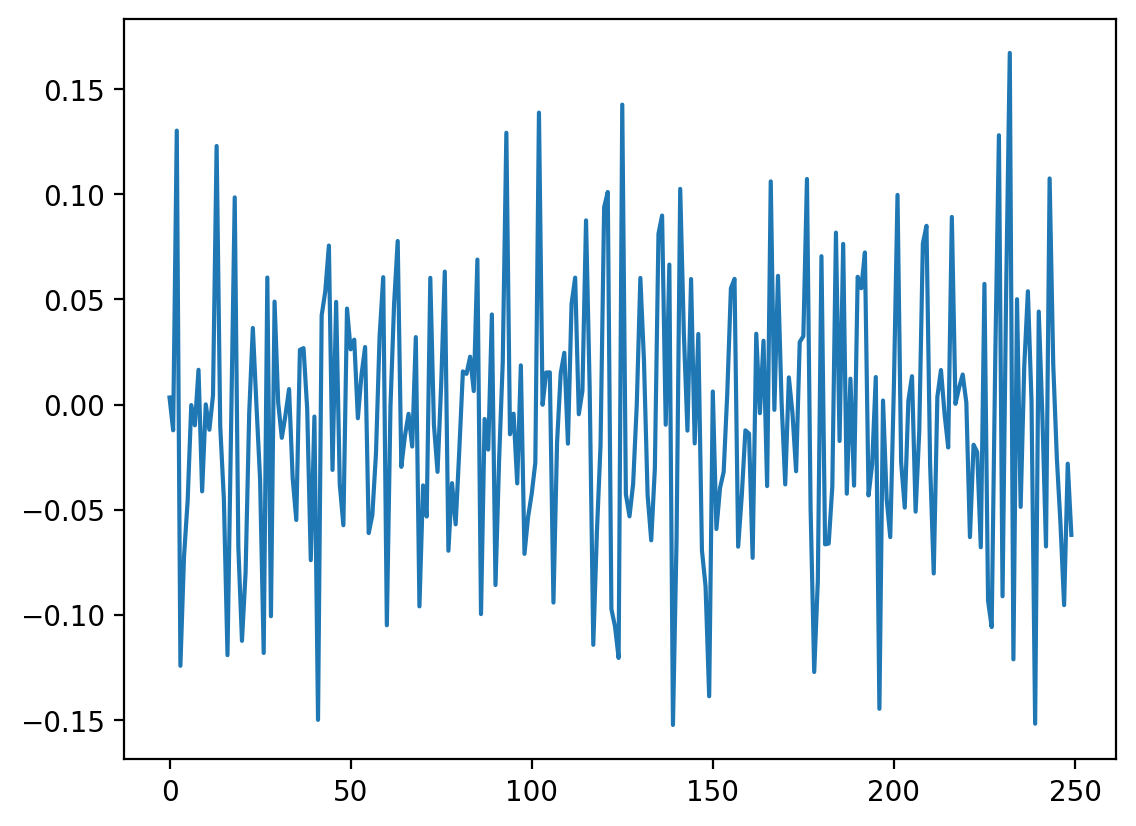

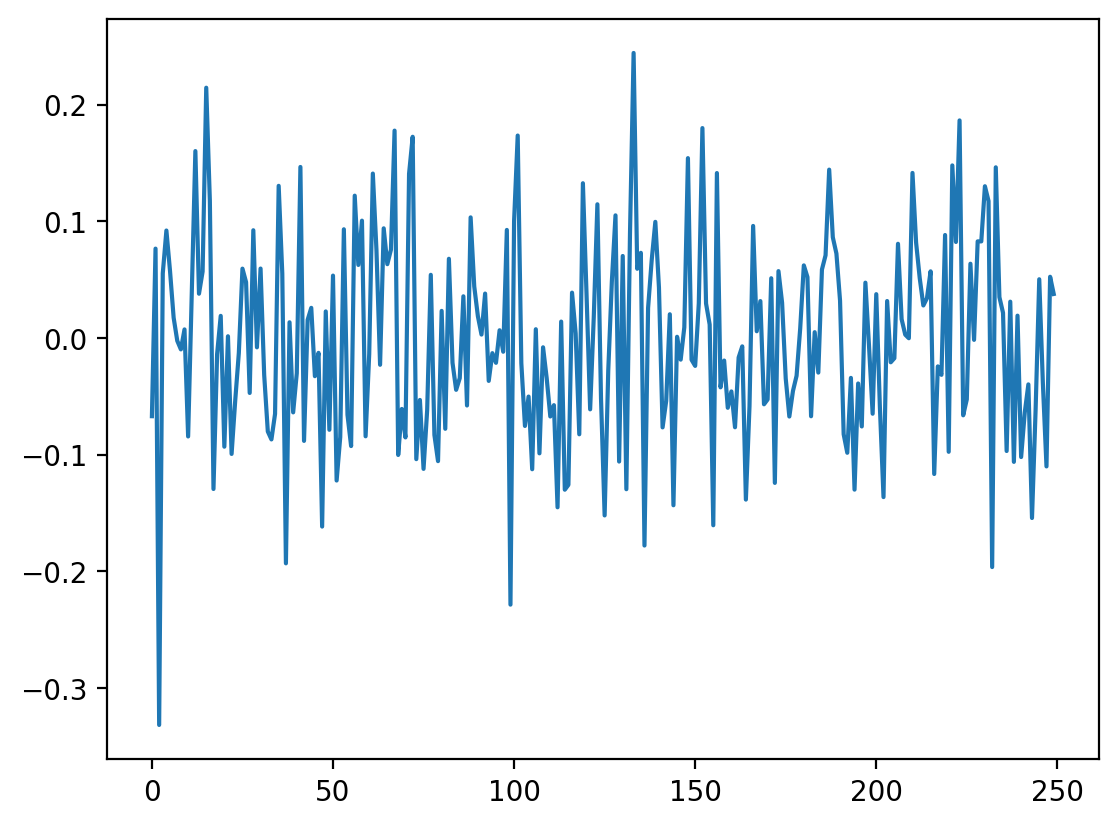

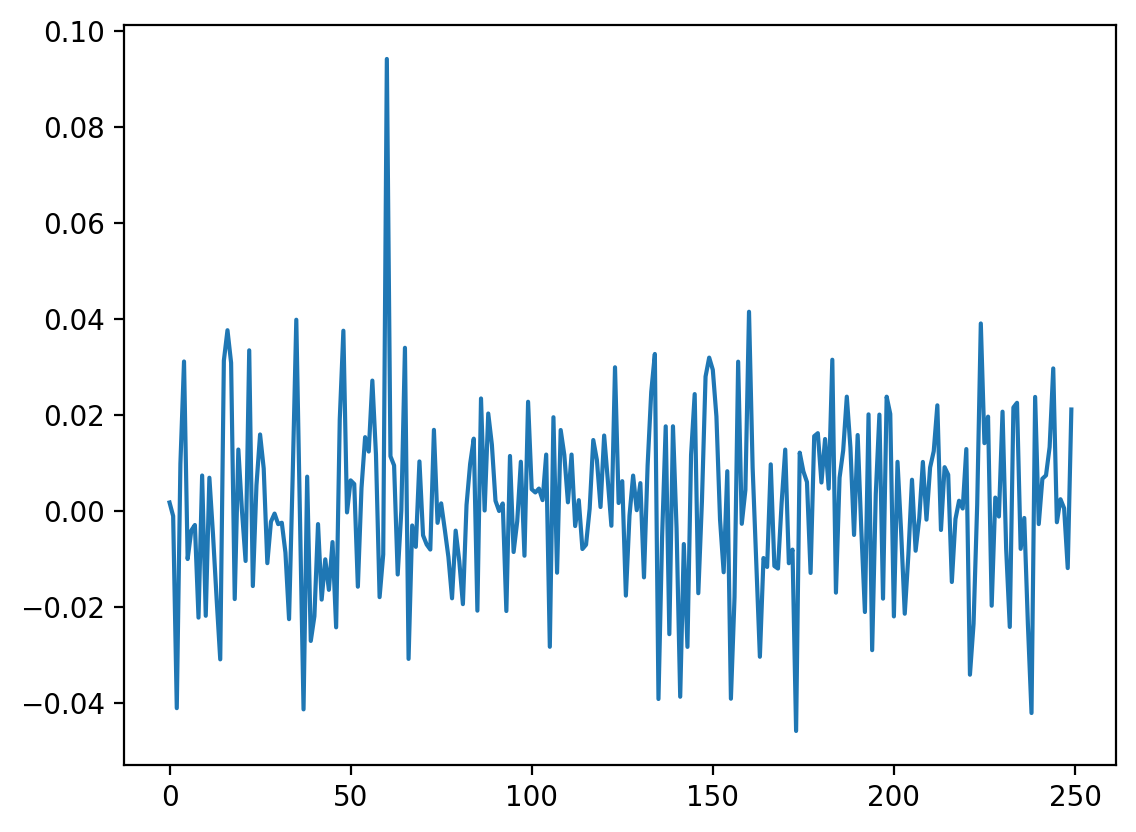

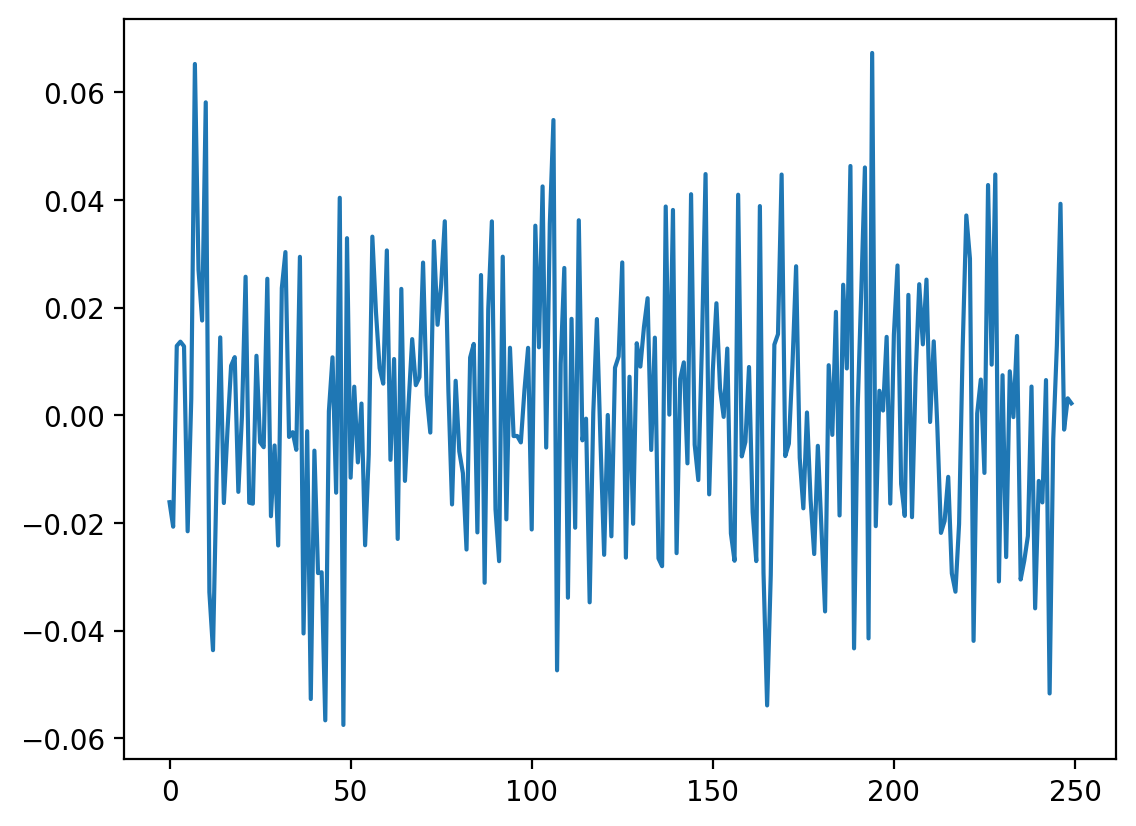

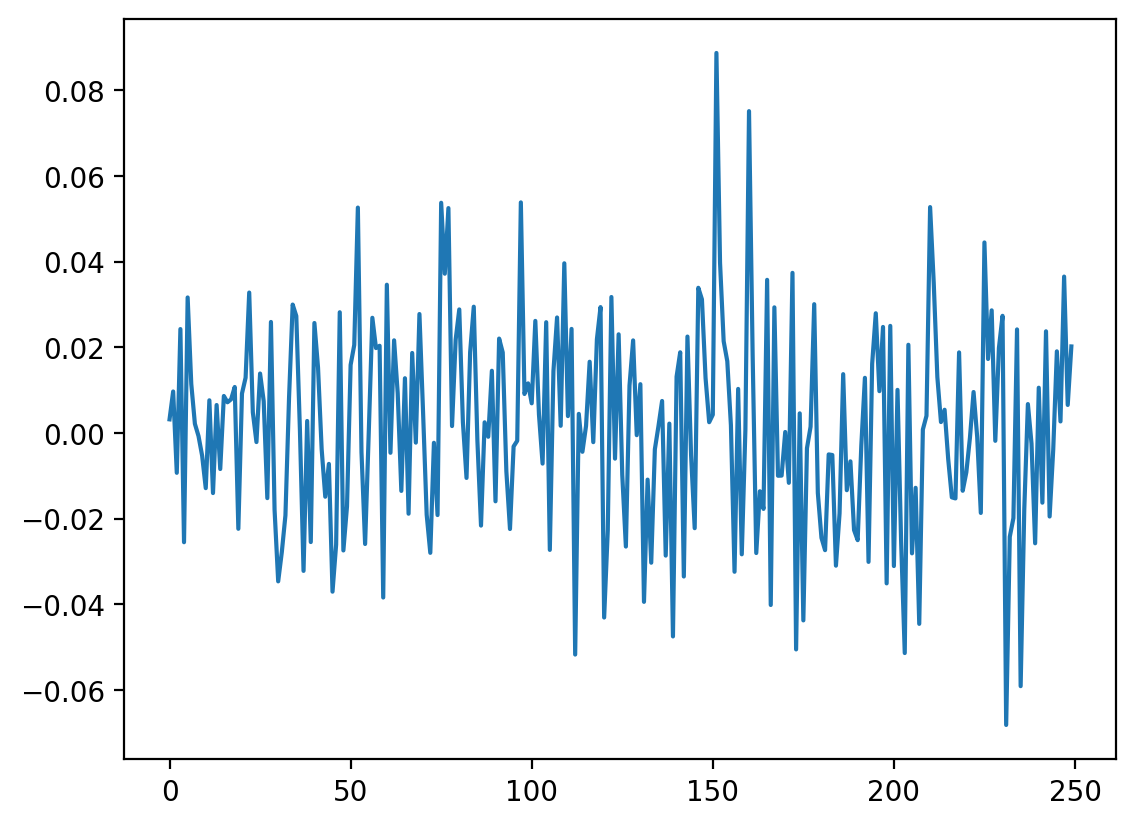

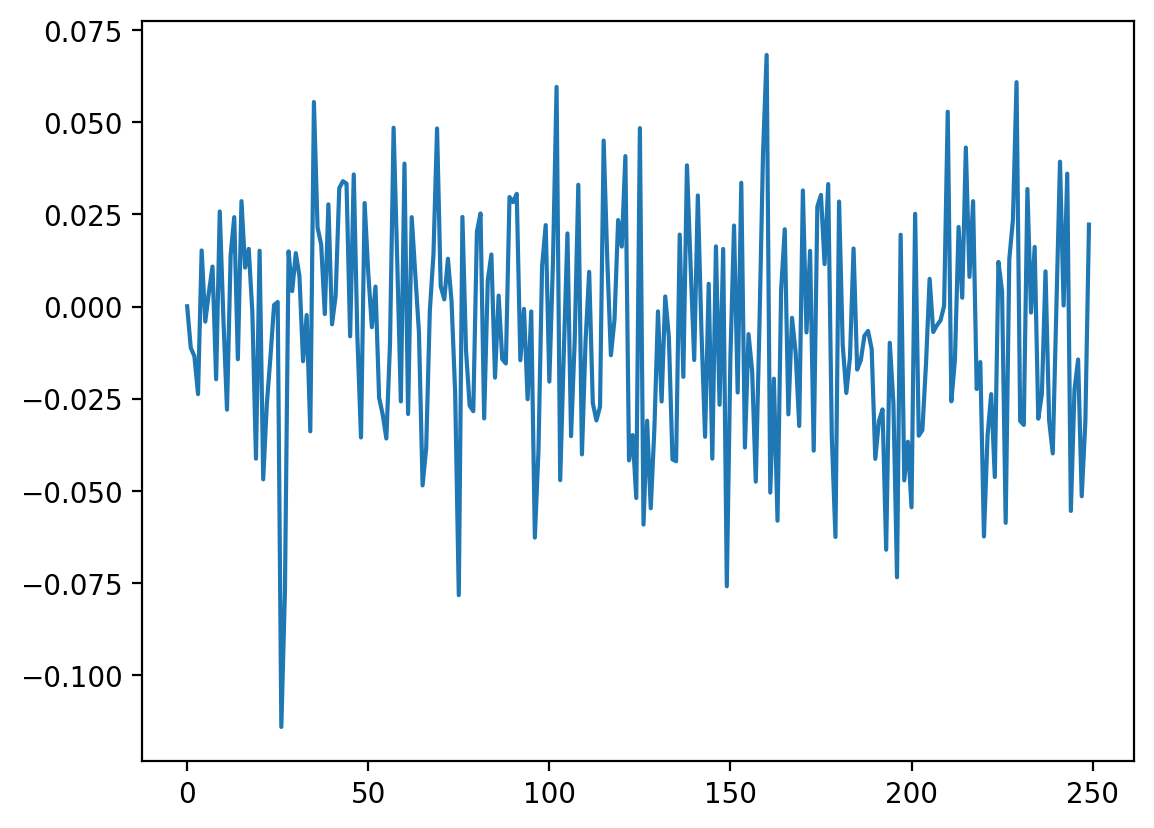

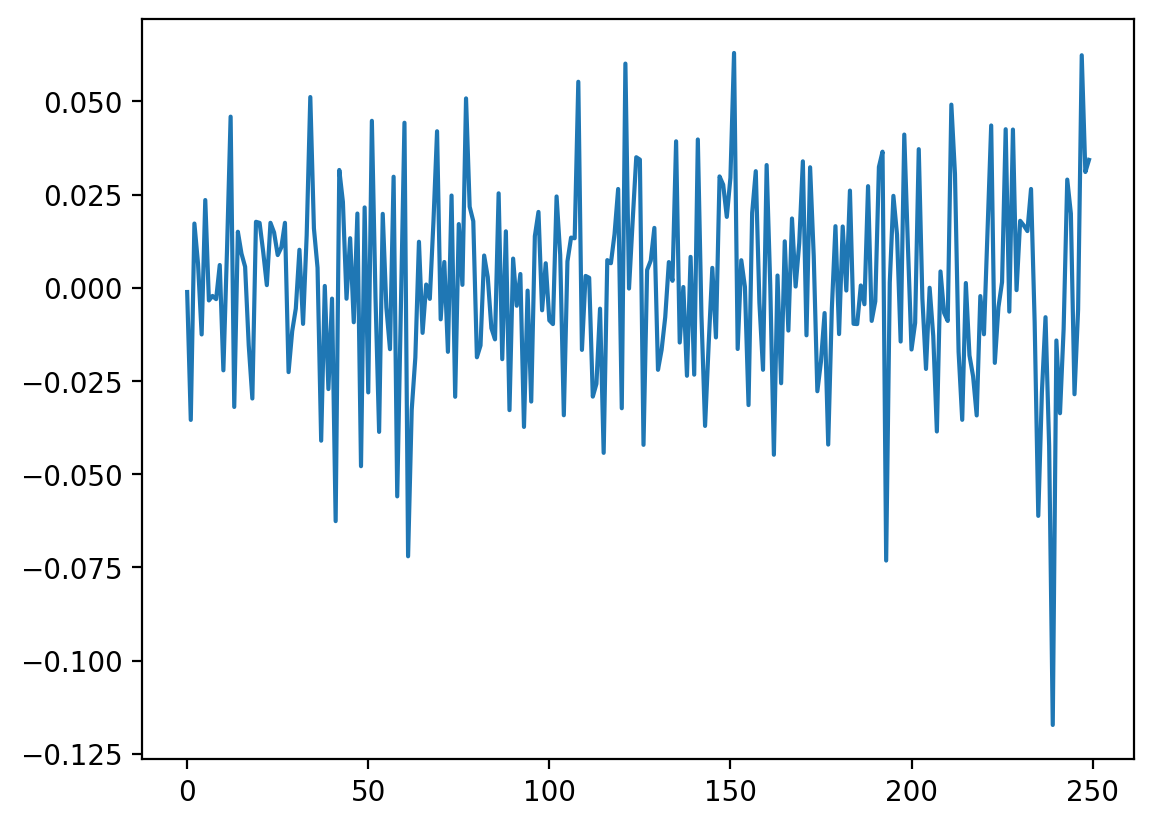

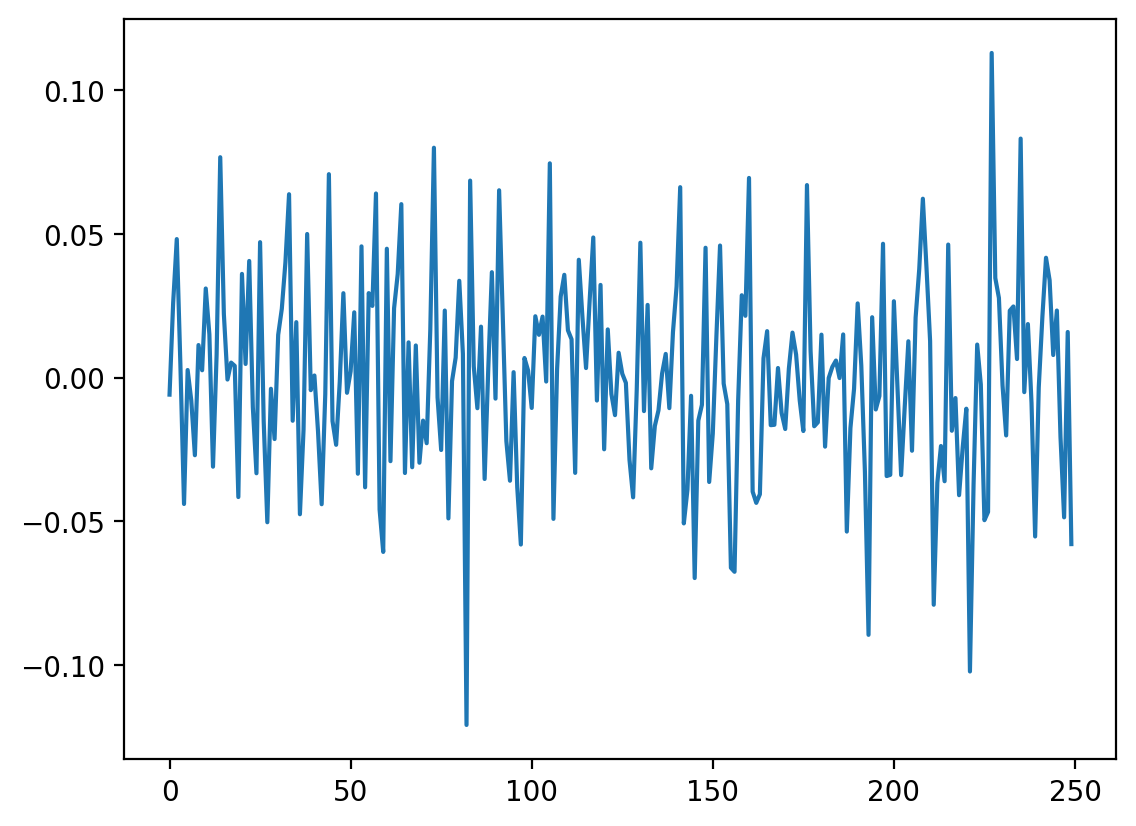

In [338]:
samples = synthesize(vae,
           n_samples=10)

In [320]:
class VariationalEncoder2(nn.Module):
    def __init__(self):
        super(VariationalEncoder2, self).__init__()
        self.linear1 = nn.Linear(250, 80).double()
        self.linear2 = nn.Linear(80, 40).double()
        self.linear3 = nn.Linear(40, 20).double()
        self.linear4 = nn.Linear(20, 10).double()
        self.linear5 = nn.Linear(20, 10).double()
        self.N = torch.distributions.Normal(0,1)
        # self.N = torch.distributions.Normal(
        #     torch.tensor(0).to(device=device), 
        #     torch.tensor(1).to(device=device))
        # self.N.loc = self.N.loc.mps() # hack to get sampling on the GPU
        # self.N.scale = self.N.scale.mps()
        self.kl = 0
    
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        mu = self.linear4(x)
        sigma = torch.exp(self.linear5(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [322]:
class VaretionalDecoder2(nn.Module):
    def __init__(self):
        super(VaretionalDecoder2, self).__init__()
        self.linear1 = nn.Linear(10, 20).double()
        self.linear2 = nn.Linear(20, 40).double()
        self.linear3 = nn.Linear(40, 80).double()
        self.linear4 = nn.Linear(80, 160).double()
        self.linear5 = nn.Linear(160, 250).double()
        
    def forward(self, z):
        z = F.leaky_relu(self.linear1(z))
        z = F.leaky_relu(self.linear2(z))
        z = F.leaky_relu(self.linear3(z))
        z = F.leaky_relu(self.linear4(z))
        z = self.linear5(z)
        # print(z.shape)
        z = z.reshape(363, 250)
        # print(z.shape)
        return z

In [323]:
class VariationalAutoencoder2(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder2, self).__init__()
        self.encoder = VariationalEncoder2()
        self.decoder = VaretionalDecoder2()
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [324]:
vae2 = VariationalAutoencoder2().to(device) # GPU

Epoch 1/5, batch 0 ,Loss=tensor(246.6902, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 1 ,Loss=tensor(248.2900, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 2 ,Loss=tensor(241.3737, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 3 ,Loss=tensor(235.2508, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 4 ,Loss=tensor(231.6365, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 5 ,Loss=tensor(227.8277, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 6 ,Loss=tensor(230.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 7 ,Loss=tensor(227.8571, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 8 ,Loss=tensor(221.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 9 ,Loss=tensor(209.2477, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 10 ,Loss=tensor(207.1794, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1/5, batch 11 ,Loss=tensor(196.8332,

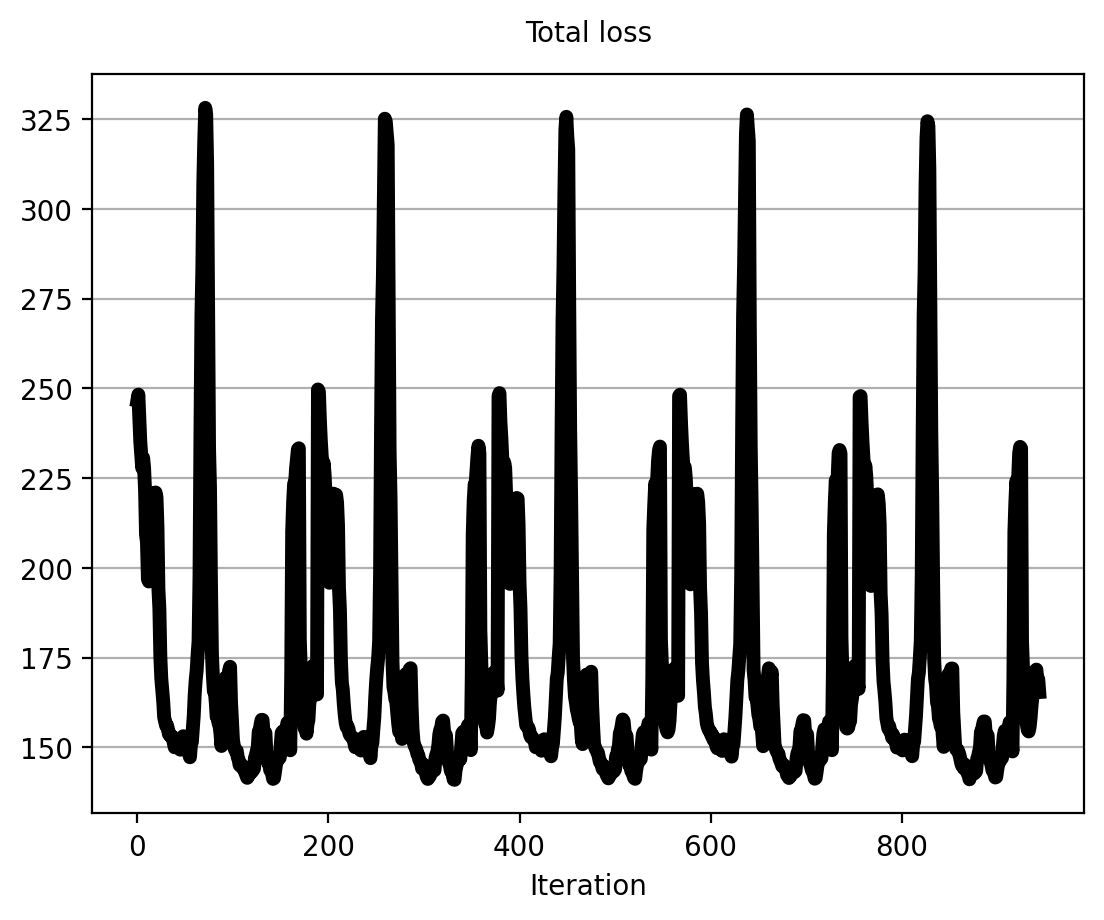

In [346]:
vae2 = train_vae(vae2, data, epochs=5, learning_rate=0.001, lambda_rec=1, lambda_reg=0.1)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_17891/238154398.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1] ,cmap='tab10')


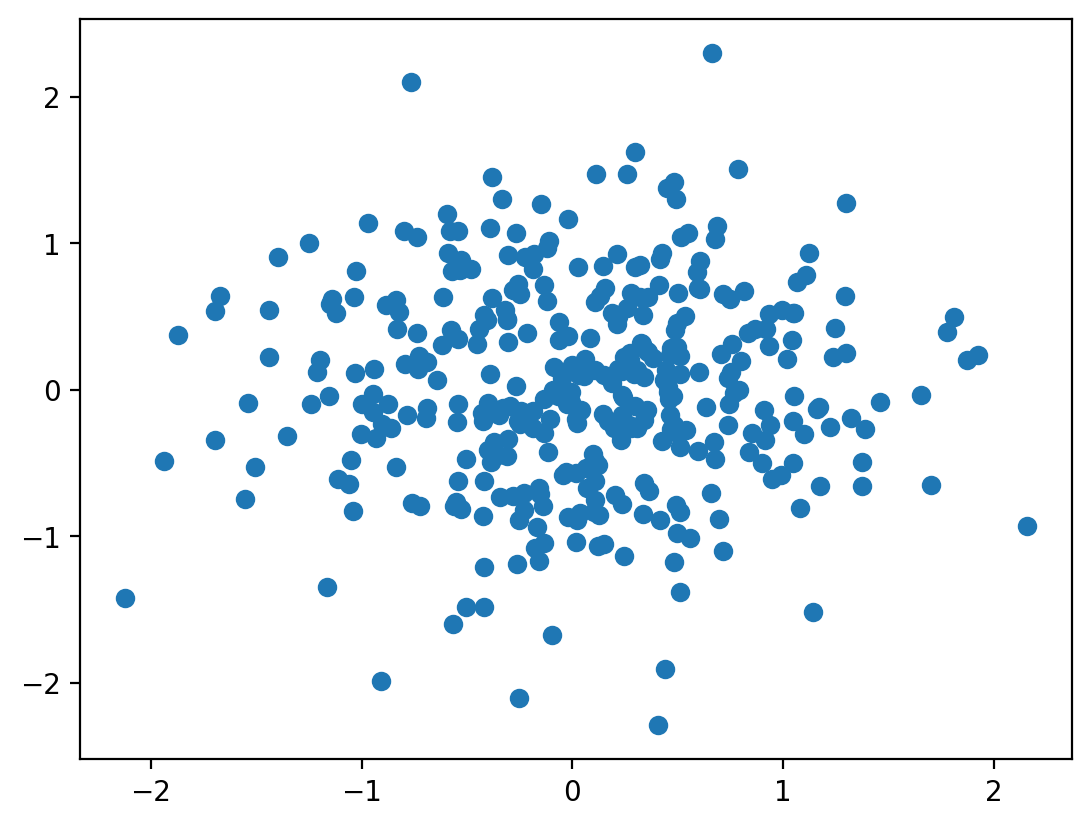

In [347]:
z = plot_latent(vae2, data)

In [348]:
z.shape

(363, 10)

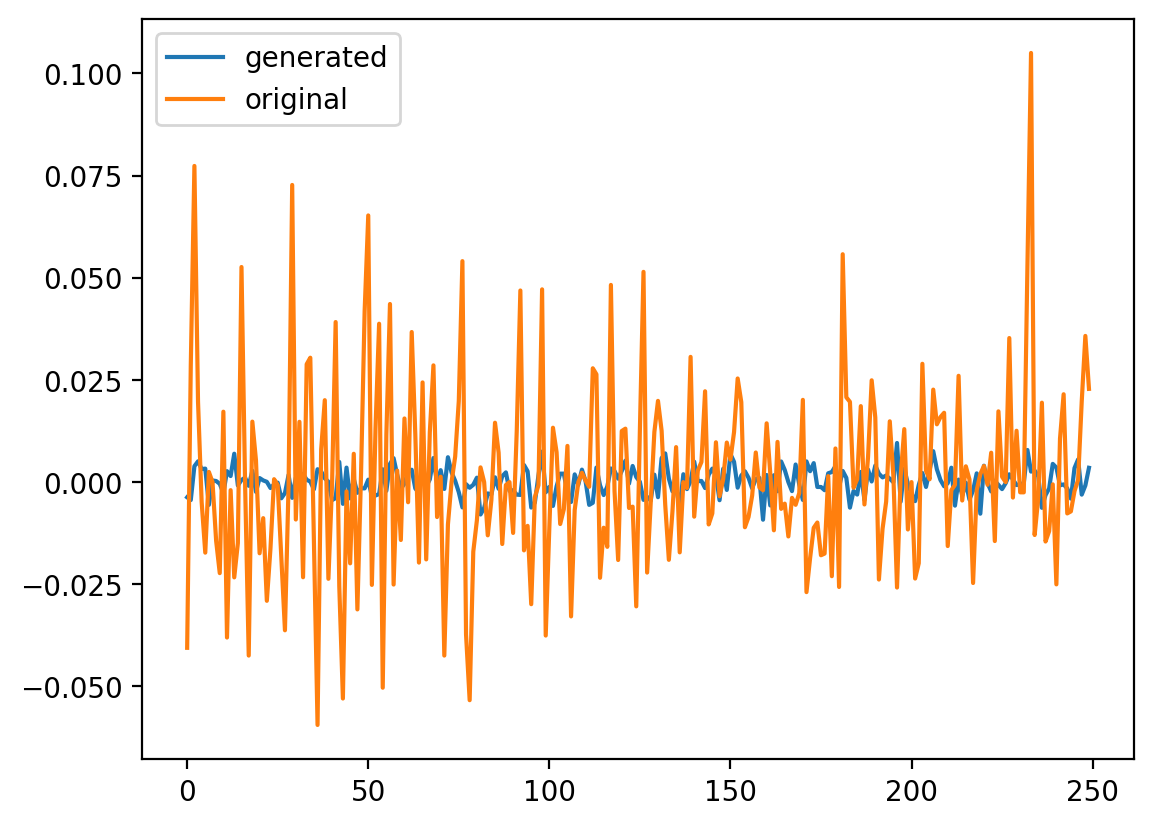

In [349]:
batch= data[0]
batch= np.transpose(batch)
x = torch.from_numpy(batch)
z = vae2.encoder(x.to(device))
x_hat = vae2.decoder(z)
x_hat = x_hat.to('cpu').detach().numpy()
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

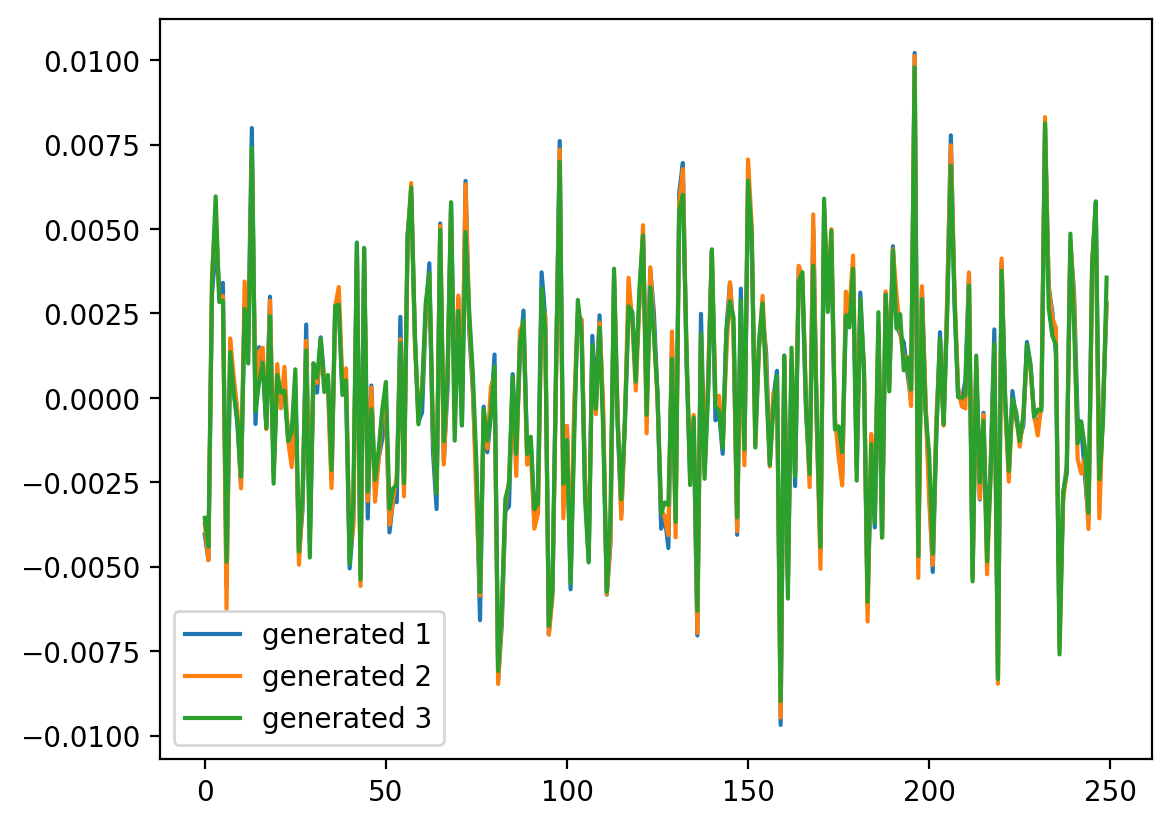

In [350]:
plt.plot(x_hat[5, :], label='generated 1')
plt.plot(x_hat[10, :], label='generated 2')
plt.plot(x_hat[100, :], label='generated 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

torch.Size([363, 10])


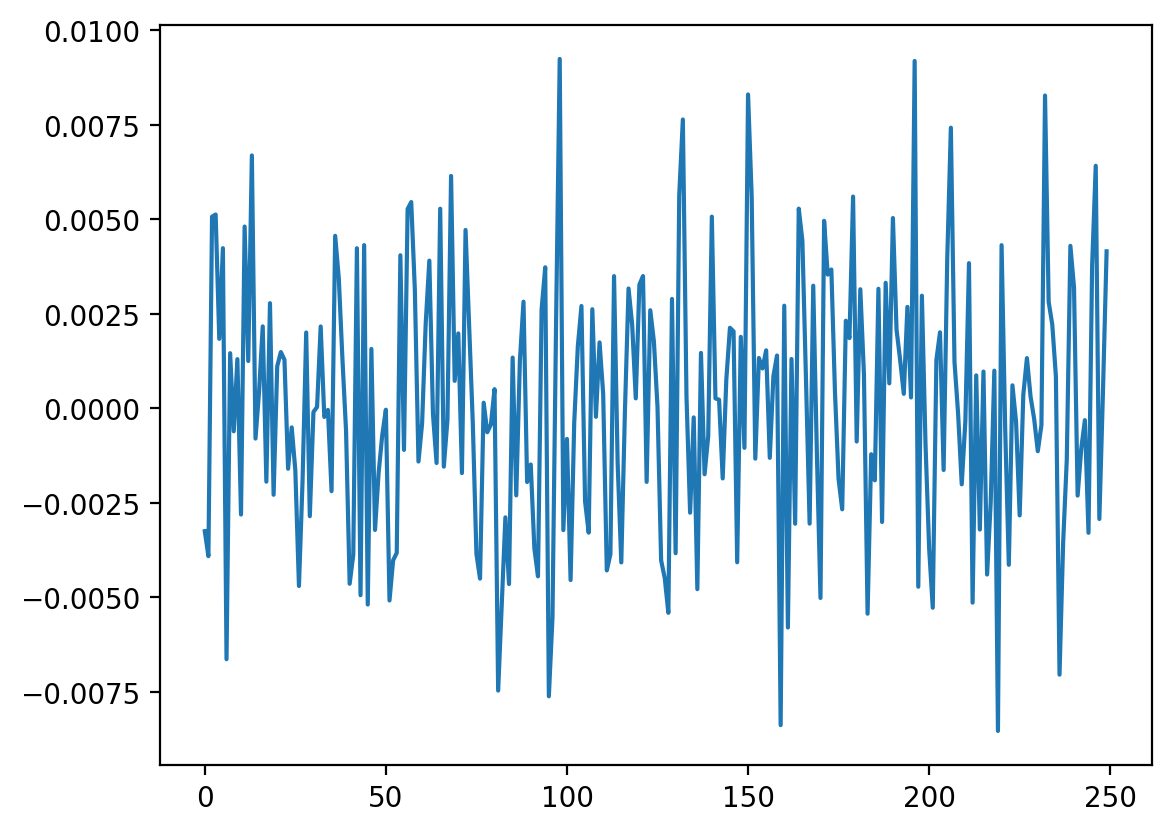

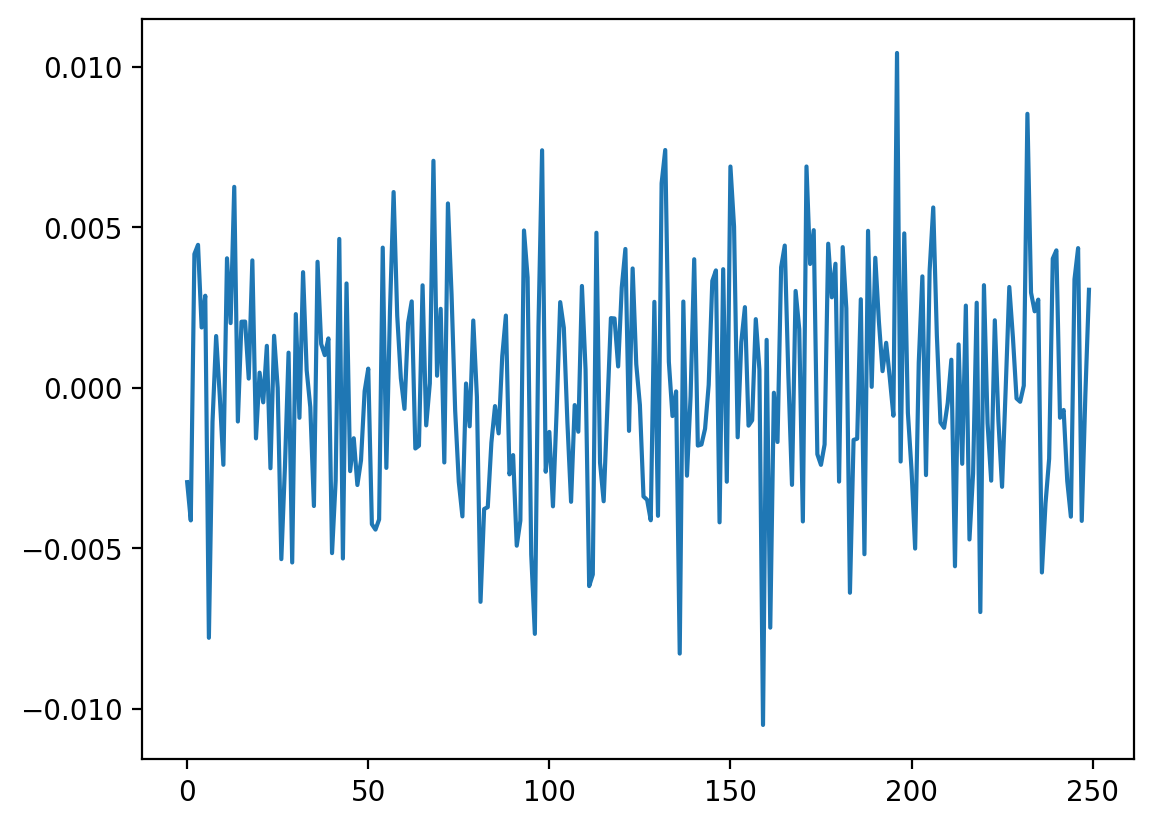

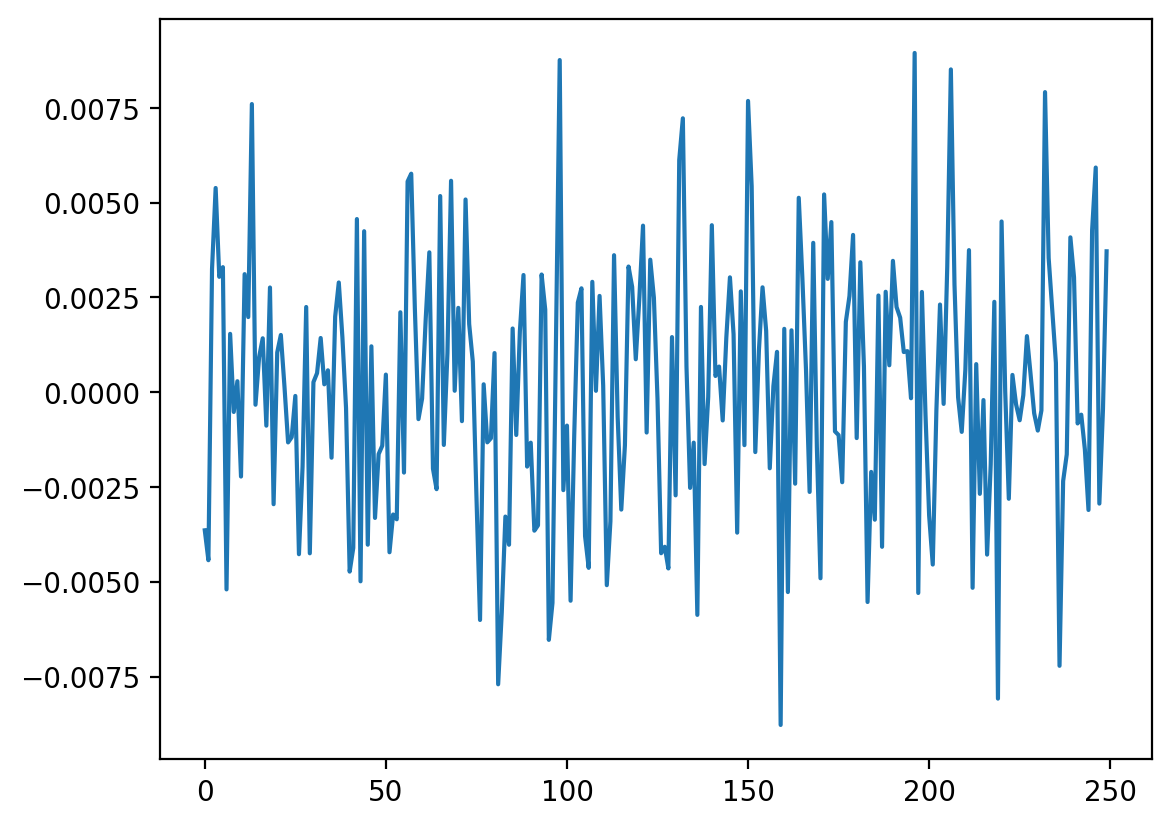

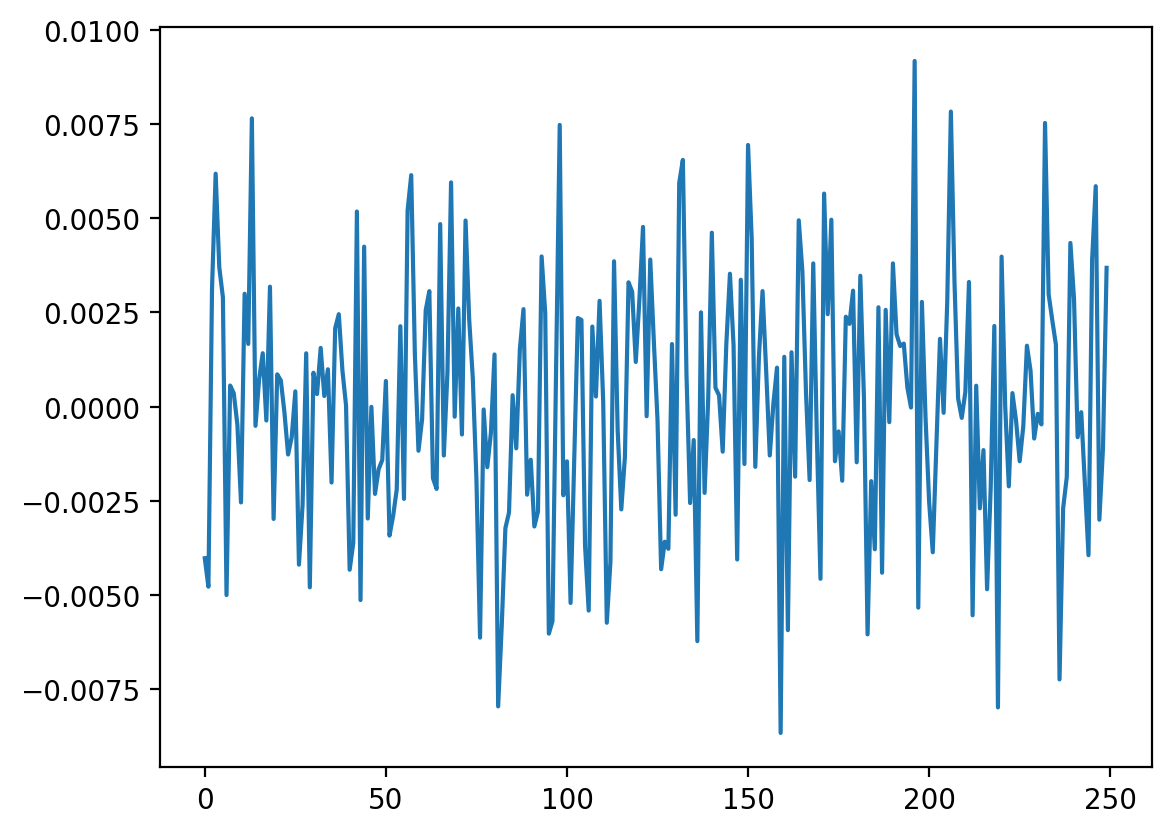

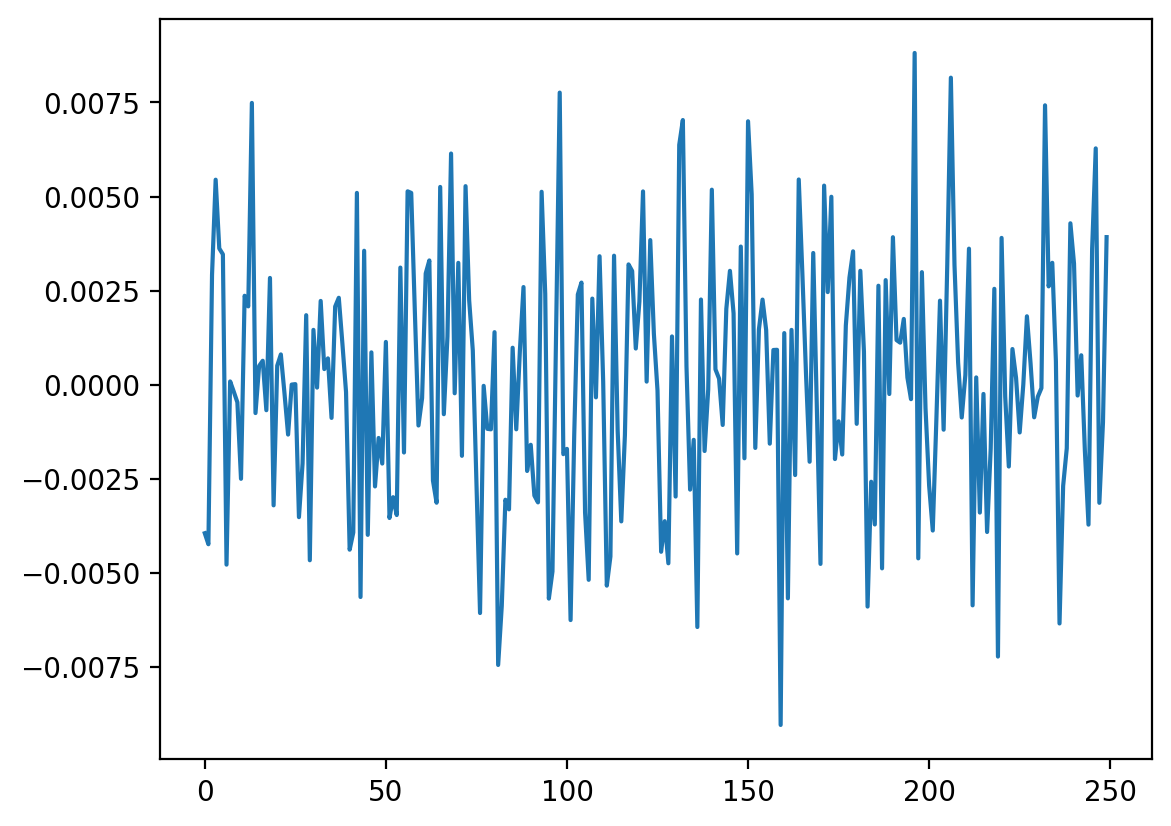

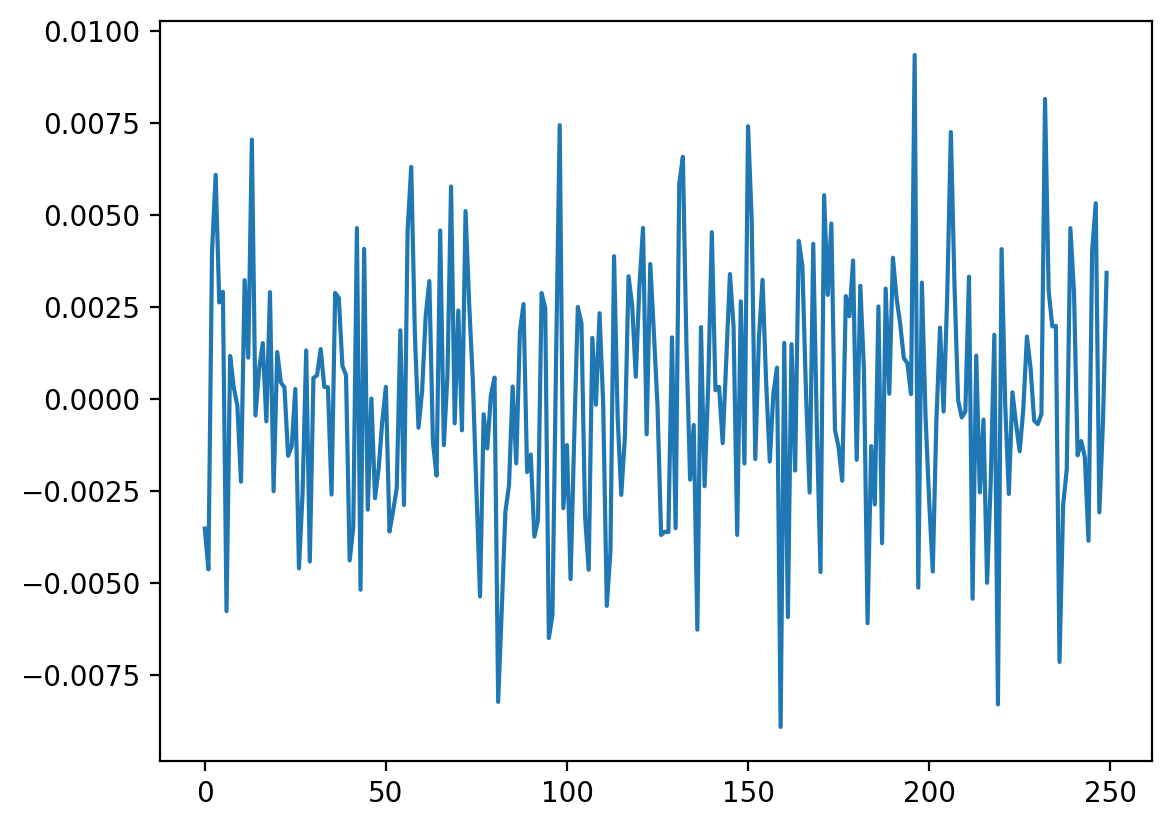

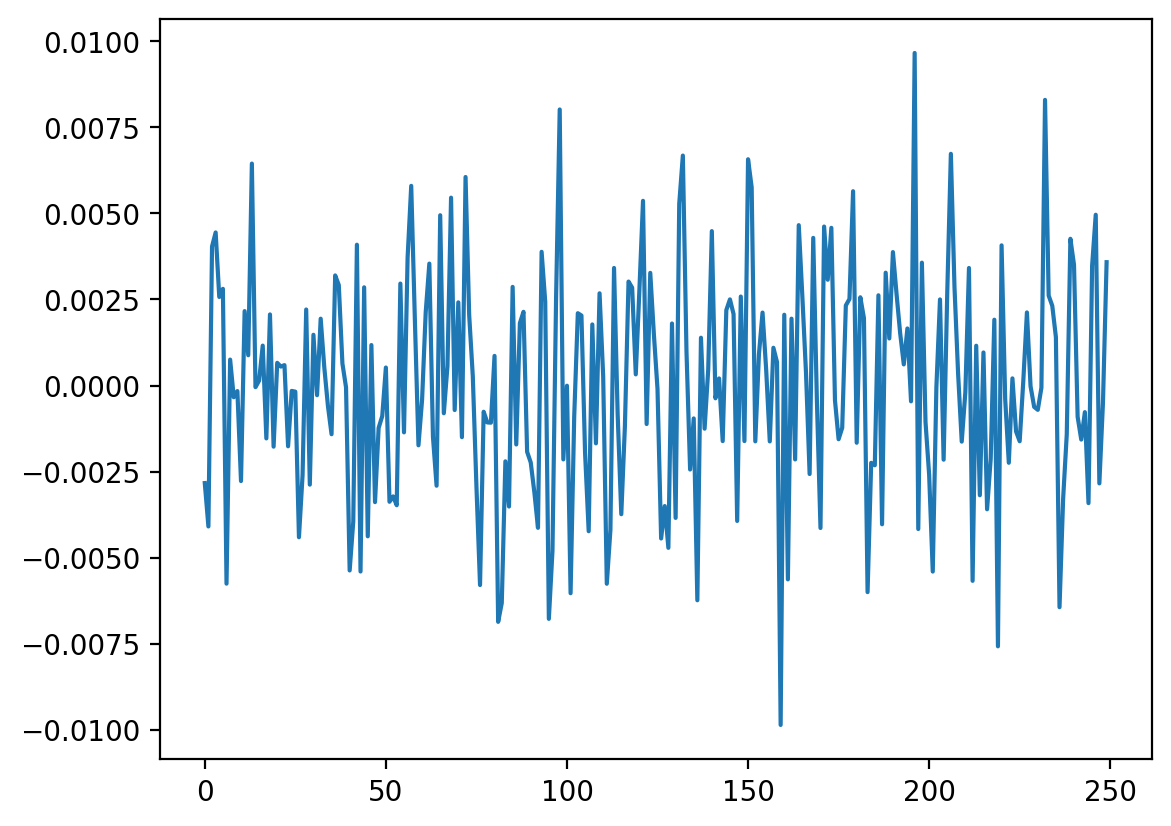

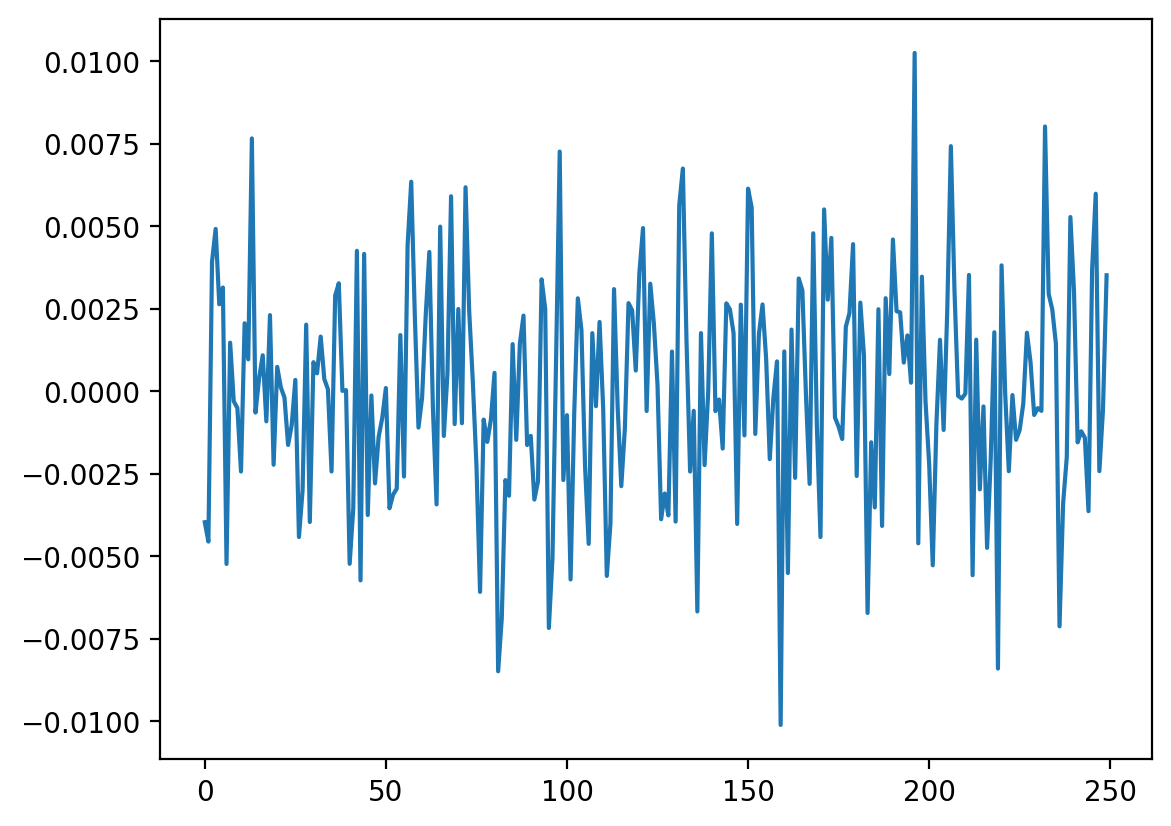

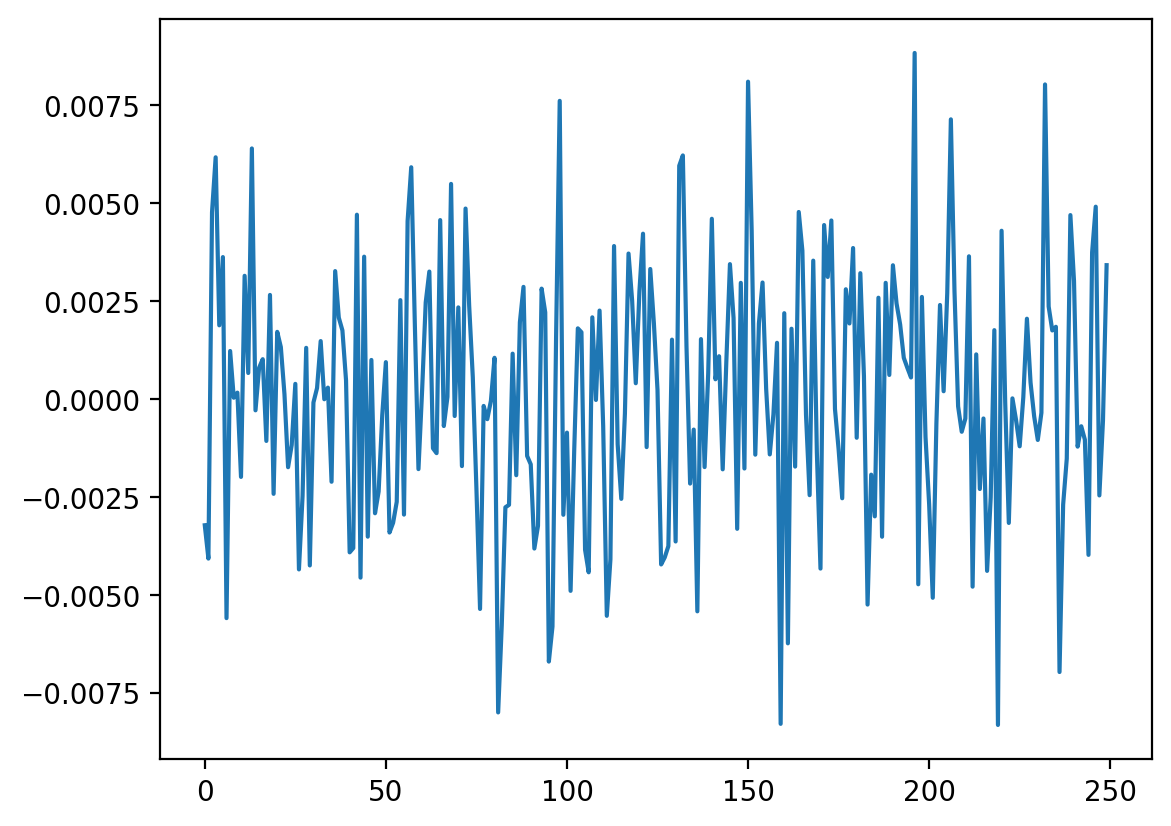

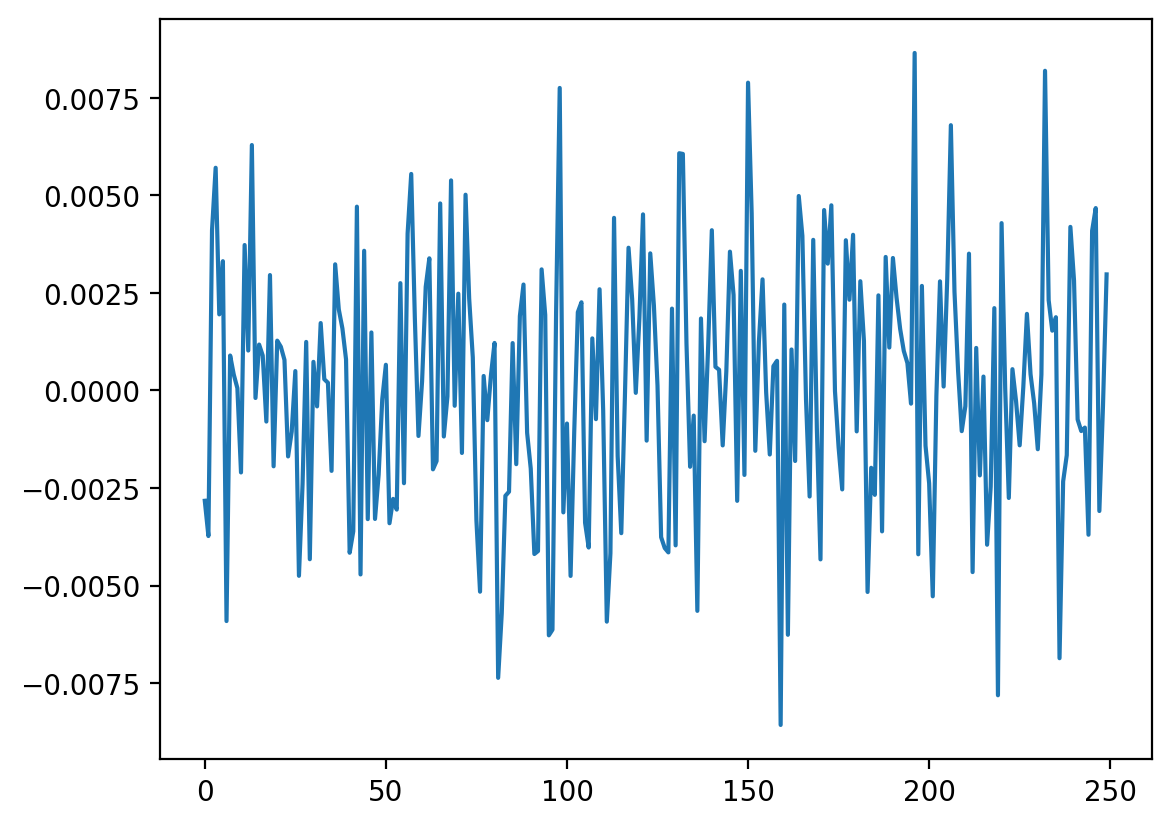

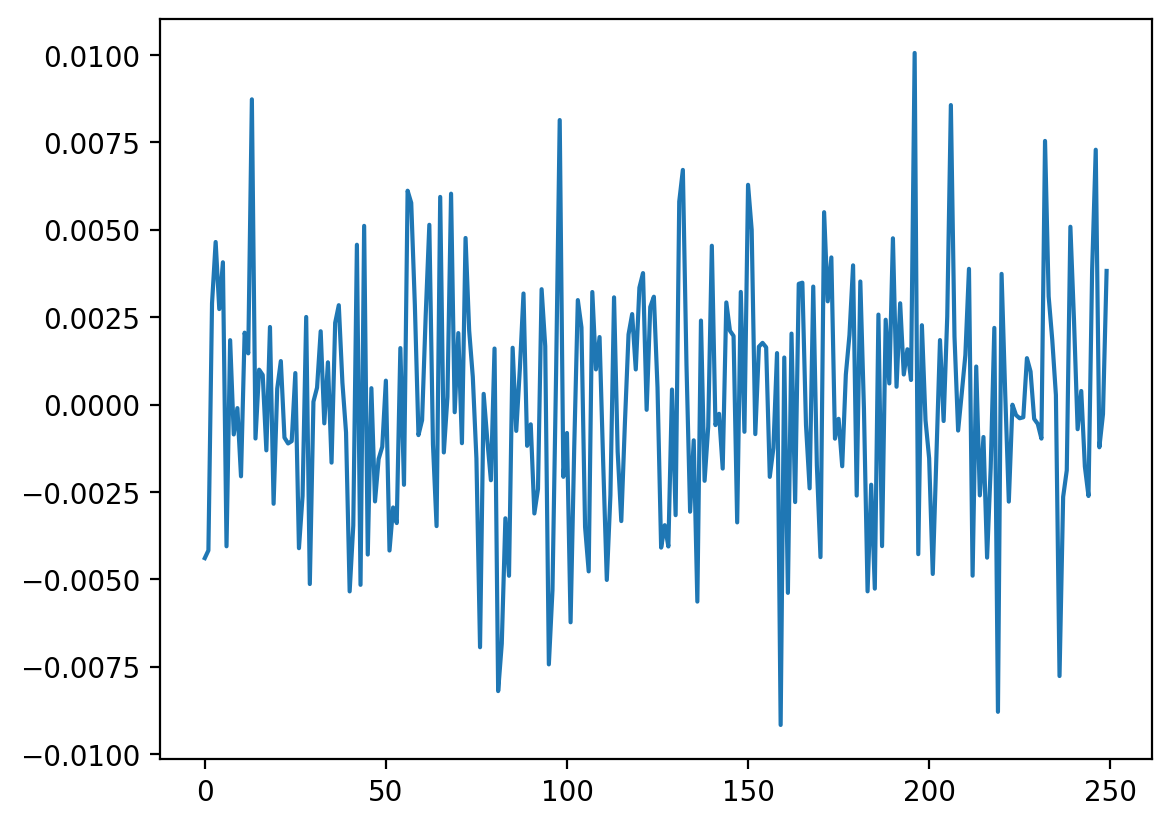

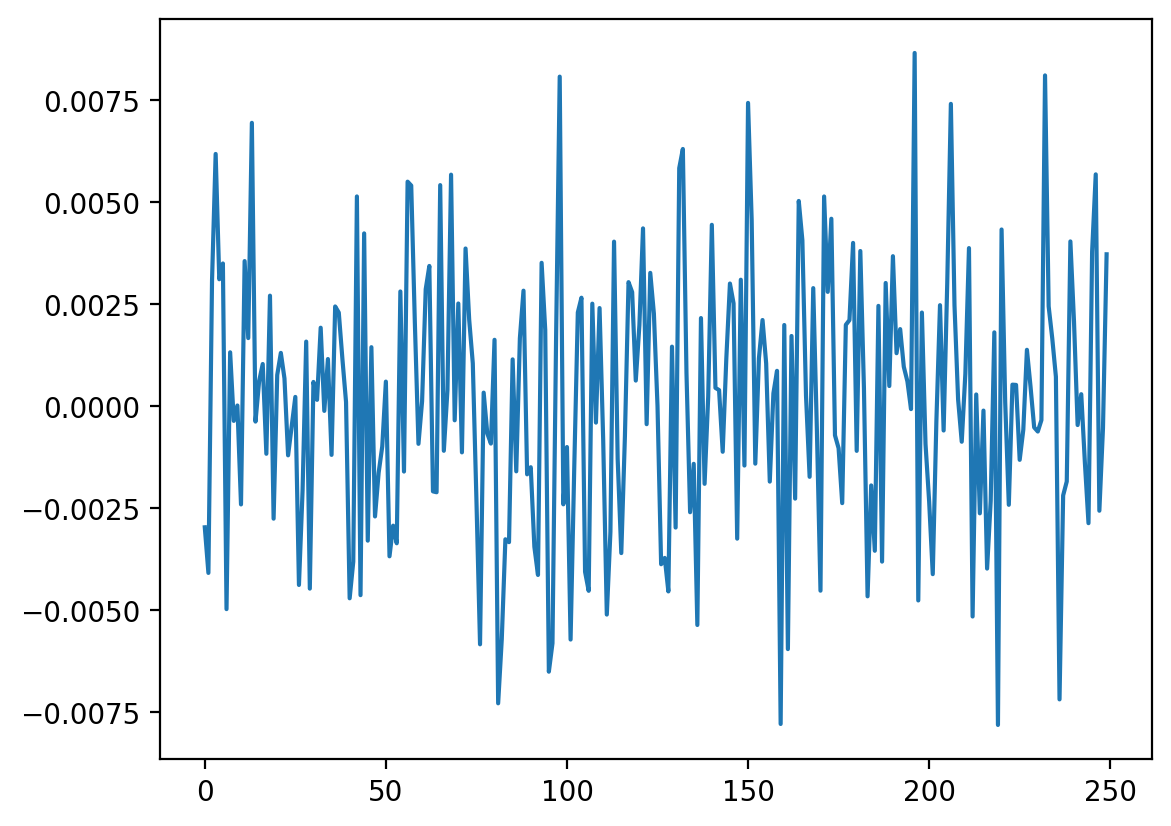

In [353]:
samples = synthesize(vae2,
           n_samples=10, z_dims=10)

# GAN

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(250, 125).double()
        self.linear2 = nn.Linear(125, latent_dims).double()
        self.linear3 = nn.Linear(125, latent_dims).double()
        self.N = torch.distributions.Normal(0,1)
        # self.N = torch.distributions.Normal(
        #     torch.tensor(0).to(device=device), 
        #     torch.tensor(1).to(device=device))
        # self.N.loc = self.N.loc.mps() # hack to get sampling on the GPU
        # self.N.scale = self.N.scale.mps()
        self.kl = 0
    
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 125).double()
        self.linear2 = nn.Linear(125, 250).double()
        
    def forward(self, z):
        z = F.leaky_relu(self.linear1(z))
        z = self.linear2(z)
        # print(z.shape)
        z = z.reshape(363, 250)
        # print(z.shape)
        return z